# Segmented GLM for top N tld registrars (by domain count) and Aggregated RF for the rest 

In [1]:
library(dplyr)
library(data.table)
library(partykit)
library(tictoc)
library(caret)
library(e1071)
library(randomForest)
library(ranger)

#for 3d plotting
library(akima)
library(plotly)

# for prep data
library(rPython)
library(stringr)
library(pbapply)
library(stringdist)
library(data.table)

getwd()


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: grid

Loading required package: libcoin

Loading required package: mvtnorm

Loading required package: lattice

Loading required package: ggplot2

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘ranger’


The following object is masked from ‘package:randomForest’:

    importance



Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:sta

[1] "/home/jupyter/local/Domains_202003/scripts/phaseII_gcloudaccess"

In [70]:

source('../orig/functions.R')

source('../orig/functions_models.R')

source('functions_eval.R')

# source('load_prep_data_expiry.R')


# Define top N tld_registrars (right now in perf_segmentation_tld_reg)

In [5]:
N=15
tld_registrars = c('sitegmo','funalibaba','sitenamecheap','pwnamecheap','onlinego daddy','sitegandi sas','sitereg.ru','onlinenamecheap','siteonlinenic',
                   'hostnamecheap','sitezhengzhou century connect','funchengdu west','spacego daddy','websitenamecheap','funnamecheap')

# Seg_GLM for top 15 tld_registrars

In [6]:
filename = 'seg_glm_expiry_exptest'
system(paste(sprintf("gsutil cp gs://data_input/%s /home/jupyter/local/Domains_202003/data/", filename)))
seg_glm_expiry_exptest <- readRDS(file.path("/home/jupyter/local/Domains_202003/data/", filename))

In [8]:
seg_glm_expiry_exptest_sub <- seg_glm_expiry_exptest %>% filter(tld_registrar_index %in% tld_registrars)

In [9]:
dim(seg_glm_expiry_exptest_sub)/dim(seg_glm_expiry_exptest)

[1] 0.4796747 1.0000000

In [17]:
head(seg_glm_expiry_exptest_sub)

renewal_type,renewed_count,expiry_date,domain_id,domain,creation_date,status,tld,registrar,reseller,⋯,sld_length,sld_type2,day_domains,log_reg_arpt,gibb_score,pattern,cluster,pattern_score,pattern_domain_count,first_renewal_prediction
<chr>,<int>,<date>,<int>,<chr>,<date>,<chr>,<fct>,<chr>,<chr>,⋯,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>
FirstTime,1,2020-01-05,58999453,joymee.fun,2018-01-05,Active,fun,alibaba,alibaba,⋯,6,6l,1,1.558145,3.81,joymee,1,1,1,0.3892428
FirstTime,1,2020-01-07,59109488,prophet.fun,2018-01-07,Active,fun,alibaba,alibaba,⋯,7,7l,1,1.558145,6.76,prophet,1,1,1,0.3677247
FirstTime,1,2020-01-17,59590658,fuyintv.fun,2018-01-17,Active,fun,alibaba,alibaba,⋯,7,7l,1,1.558145,0.97,fuyintv,1,1,1,0.3334929
FirstTime,1,2020-01-21,59849738,mul.fun,2018-01-21,Active,fun,alibaba,alibaba,⋯,3,3l,1,1.558145,5.71,mul,1,1,1,0.5258015
FirstTime,1,2020-02-05,60613428,12138.fun,2018-02-05,Active,fun,alibaba,alibaba,⋯,5,5n,1,1.558145,100.00,12138,1,1,1,0.4359649
FirstTime,1,2020-02-07,60745783,yimo.fun,2018-02-07,Active,fun,alibaba,alibaba,⋯,4,4l,1,1.558145,4.61,yimo,1,1,1,0.4766606


# RF on the rest (51.6%)

In [13]:
tld_registrars
num_trees = 1000
train = expiry_train_df_sub
test = expiry_test_df_sub


train$tld_registrar_index <- tolower(paste(train$tld,train$registrar,sep=""))
test$tld_registrar_index <- tolower(paste(test$tld,test$registrar,sep=""))

train <- train %>% filter(!(tld_registrar_index %in% tld_registrars))
test <- test %>% filter(!(tld_registrar_index %in% tld_registrars))

dim(train)/dim(expiry_train_df_sub)
head(train)

[1] "sitegmo"                       "funalibaba"                   
 [3] "sitenamecheap"                 "pwnamecheap"                  
 [5] "onlinego daddy"                "sitegandi sas"                
 [7] "sitereg.ru"                    "onlinenamecheap"              
 [9] "siteonlinenic"                 "hostnamecheap"                
[11] "sitezhengzhou century connect" "funchengdu west"              
[13] "spacego daddy"                 "websitenamecheap"             
[15] "funnamecheap"

[1] 0.5159301 1.0833333

renewal_status,tld,registrar,reseller_country,region,reg_period,sld_type,sld_length,day_domains,gibb_score,pattern_domain_count,reg_arpt,tld_registrar_index
<fct>,<fct>,<chr>,<chr>,<chr>,<int>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<chr>
Renewed,fun,1&1 internet,Germany,Non China,1,l,7,1,6.77,1,15,fun1&1 internet
Renewed,fun,1&1 internet,Germany,Non China,1,ln,7,1,8.65,1,15,fun1&1 internet
Renewed,fun,1&1 internet,Germany,Non China,1,l,6,1,13.09,1,15,fun1&1 internet
Not Renewd,fun,1&1 internet,Germany,Non China,1,l,12,1,2.44,1,15,fun1&1 internet
Renewed,fun,1&1 internet,Germany,Non China,1,l,7,1,2.34,1,15,fun1&1 internet
Renewed,fun,1&1 internet,Germany,Non China,1,l,8,1,3.64,1,15,fun1&1 internet


In [15]:
cat("\nTraining & Testing remaining aggregate forest.\n")

# ranger_03_reg <- ranger(
# formula         = renewal_status ~ ., 
# data            = train, 
# importance      = 'impurity', 
# num.trees       = num_trees,
#     probability     = TRUE,
# #     mtry            = 3,
# #     min.node.size   = 10,
# #     replace         = FALSE,
# #     sample.fraction = .8,
# seed            = 123
# )

ranger_predict_03_reg <- predict(ranger_03_reg, 
                                 data = test,
                                 type="response")$predictions

ranger_predict_03_reg <- as.data.frame(ranger_predict_03_reg)$Renewed


Training & Testing remaining aggregate forest.


In [19]:
test$first_renewal_prediction <- ranger_predict_03_reg
head(test)

renewal_status,tld,registrar,reseller_country,region,reg_period,sld_type,sld_length,day_domains,gibb_score,pattern_domain_count,reg_arpt,tld_registrar_index,first_renewal_prediction
<fct>,<fct>,<chr>,<chr>,<chr>,<int>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<chr>,<dbl>
Renewed,fun,1&1 internet,Germany,Non China,1,l,6,1,2.23,1,15,fun1&1 internet,0.6502946
Renewed,fun,1&1 internet,Germany,Non China,1,l,9,1,3.45,1,15,fun1&1 internet,0.6714504
Not Renewd,fun,10dencehispahard,Spain,Non China,1,l,8,1,8.62,1,15,fun10dencehispahard,0.6107611
Not Renewd,fun,10dencehispahard,Spain,Non China,1,l,6,1,3.13,1,15,fun10dencehispahard,0.5011916
Renewed,fun,1api,Germany,Non China,1,l,7,1,4.51,1,5,fun1api,0.8055027
Not Renewd,fun,1api,Germany,Non China,1,l,7,1,6.09,1,5,fun1api,0.8044683


# Aggregate Results

In [20]:
cols = names(test)
cols

[1] "renewal_status"           "tld"                     
 [3] "registrar"                "reseller_country"        
 [5] "region"                   "reg_period"              
 [7] "sld_type"                 "sld_length"              
 [9] "day_domains"              "gibb_score"              
[11] "pattern_domain_count"     "reg_arpt"                
[13] "tld_registrar_index"      "first_renewal_prediction"

In [25]:
dim(seg_glm_expiry_exptest_sub %>% select(all_of(cols)))

[1] 142366     14

In [26]:
dim(test)

[1] 152784     14

In [28]:
#1647 rows missing - INVESTIGATE
agg_results = rbind(seg_glm_expiry_exptest_sub %>% select(all_of(cols)),test)
dim(agg_results)
dim(seg_glm_expiry_exptest)
dim(seg_glm_expiry_exptest)-dim(agg_results)
head(agg_results)

[1] 295150     14

[1] 296797     40

[1] 1647   26

renewal_status,tld,registrar,reseller_country,region,reg_period,sld_type,sld_length,day_domains,gibb_score,pattern_domain_count,reg_arpt,tld_registrar_index,first_renewal_prediction
<fct>,<fct>,<chr>,<chr>,<chr>,<int>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<chr>,<dbl>
Not Renewd,fun,alibaba,China,China,2,l,6,1,3.81,1,4.75,funalibaba,0.3892428
Not Renewd,fun,alibaba,China,China,2,l,7,1,6.76,1,4.75,funalibaba,0.3677247
Renewed,fun,alibaba,China,China,2,l,7,1,0.97,1,4.75,funalibaba,0.3334929
Renewed,fun,alibaba,China,China,2,l,3,1,5.71,1,4.75,funalibaba,0.5258015
Not Renewd,fun,alibaba,China,China,2,n,5,1,100.00,1,4.75,funalibaba,0.4359649
Not Renewd,fun,alibaba,China,China,2,l,4,1,4.61,1,4.75,funalibaba,0.4766606


# Assess performance

In [29]:
df = data.frame("actual" = agg_results$renewal_status,
          "predicted" = agg_results$first_renewal_prediction)

lift_df <- chart_lift(pred_df = df,
                        dep_var = "actual",
                        pred_var = "predicted")

gains_plot <- plot_gains (lift_df) 

auc_val <- calc_auc(lift_df)


# saveRDS(lift_df_seg_glm_expiry_exptest, file.path('../../data/output/',"lift_df_seg_glm_expiry_exptest"))

In [30]:
auc_val

[1] 0.7951602

In [31]:
lift_df

P,actu_renwd2,gain,lift
<dbl>,<int>,<dbl>,<dbl>
0.1,11435,0.4240840,4.240840
0.2,16757,0.6214582,3.107291
0.3,20157,0.7475523,2.491841
0.4,22433,0.8319611,2.079903
0.5,24258,0.8996440,1.799288
0.6,25605,0.9495995,1.582666
0.7,26484,0.9821985,1.403141
0.8,26843,0.9955125,1.244391
0.9,26953,0.9995920,1.110658


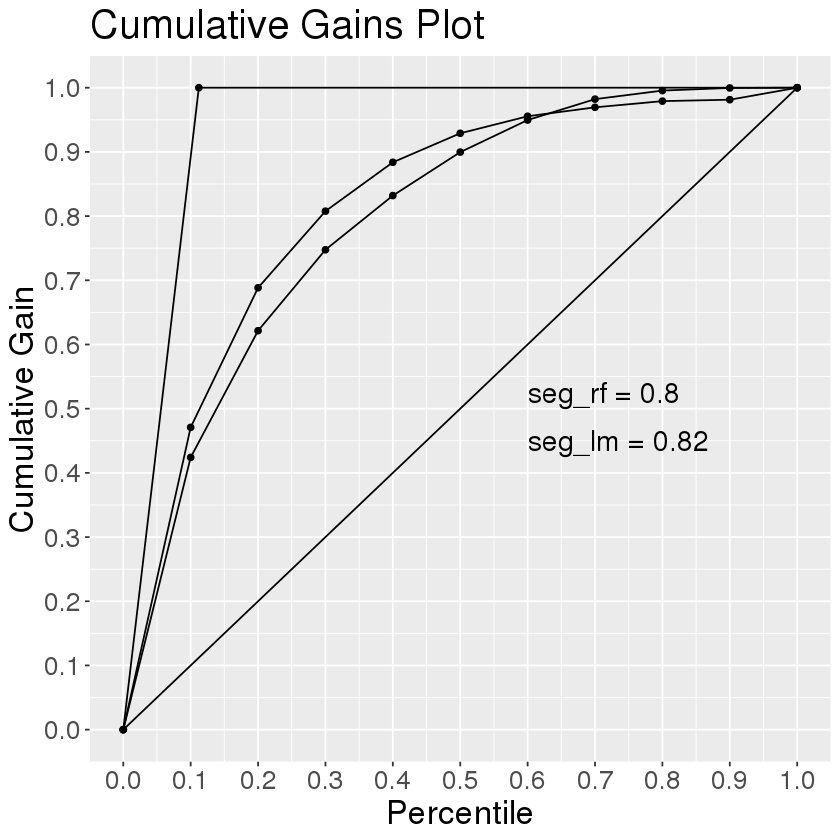

In [34]:
lift_df_seg_glm_expiry_exptest <- readRDS('../../data/lift_df_seg_glm_expiry_exptest')
plot_multigains <- plot_multigains(
    lift_df_list=list(
        seg_rf = lift_df,
        seg_15 = lift_df_seg_glm_expiry_exptest),
    auc_list = list(
        seg_rf= calc_auc(lift_df),
        seg_15= calc_auc(lift_df_seg_glm_expiry_exptest)))
# png(file = "../../data/output/plot_multigains_03_summ5.png",
#     width = 500, height = 375)
plot(plot_multigains)
# dev.off()

# top 50

In [35]:
top_tld_reg <- seg_glm_expiry_exptest %>% group_by(tld_registrar_index) %>% count() %>% arrange(desc(n)) %>% head(50) %>% select(n)
sum(top_tld_reg$n)

sum(top_tld_reg$n)/nrow(seg_glm_expiry_exptest)

tld_registrars = top_tld_reg$tld_registrar_index
tld_registrars

Adding missing grouping variables: `tld_registrar_index`



[1] 217874

[1] 0.7340842

[1] "sitegmo"                       "funalibaba"                   
 [3] "sitenamecheap"                 "pwnamecheap"                  
 [5] "onlinego daddy"                "sitegandi sas"                
 [7] "sitereg.ru"                    "onlinenamecheap"              
 [9] "siteonlinenic"                 "hostnamecheap"                
[11] "sitezhengzhou century connect" "funchengdu west"              
[13] "spacego daddy"                 "websitenamecheap"             
[15] "funnamecheap"                  "sitealibaba"                  
[17] "onlinehostinger"               "spacenamecheap"               
[19] "websiteuniregistrar"           "onlinealibaba"                
[21] "onlinefbs"                     "sitego daddy"                 
[23] "sitechengdu west"              "storealibaba"                 
[25] "onlinechengdu west"            "storego daddy"                
[27] "online1&1 internet"            "onlinedynadot"                
[29] "pwgo daddy"                    "techhostinger"                
[31] "spacereg.ru"                   "sitehostinger"                
[33] "sitenetwork solutions"         "websitereg.ru"                
[35] "funreg.ru"                     "onlinebigrock"                
[37] "websitego daddy"               "pwgandi sas"                  
[39] "storehostinger"                "techchengdu west"             
[41] "sitefbs"                       "siteurl solutions"            
[43] "onlinereg.ru"                  "storeshopify"                 
[45] "onlineuniregistrar"            "onlineversio"                 
[47] "techgo daddy"                  "funzhengzhou century connect" 
[49] "spaceurl solutions"            "pwpdr ltd"

In [36]:
seg_glm_expiry_exptest_sub <- seg_glm_expiry_exptest %>% filter(tld_registrar_index %in% tld_registrars)

In [37]:
tld_registrars
num_trees = 1000
train = expiry_train_df_sub
test = expiry_test_df_sub


train$tld_registrar_index <- tolower(paste(train$tld,train$registrar,sep=""))
test$tld_registrar_index <- tolower(paste(test$tld,test$registrar,sep=""))

train <- train %>% filter(!(tld_registrar_index %in% tld_registrars))
test <- test %>% filter(!(tld_registrar_index %in% tld_registrars))

dim(train)/dim(expiry_train_df_sub)
head(train)

[1] "sitegmo"                       "funalibaba"                   
 [3] "sitenamecheap"                 "pwnamecheap"                  
 [5] "onlinego daddy"                "sitegandi sas"                
 [7] "sitereg.ru"                    "onlinenamecheap"              
 [9] "siteonlinenic"                 "hostnamecheap"                
[11] "sitezhengzhou century connect" "funchengdu west"              
[13] "spacego daddy"                 "websitenamecheap"             
[15] "funnamecheap"                  "sitealibaba"                  
[17] "onlinehostinger"               "spacenamecheap"               
[19] "websiteuniregistrar"           "onlinealibaba"                
[21] "onlinefbs"                     "sitego daddy"                 
[23] "sitechengdu west"              "storealibaba"                 
[25] "onlinechengdu west"            "storego daddy"                
[27] "online1&1 internet"            "onlinedynadot"                
[29] "pwgo daddy"                    "techhostinger"                
[31] "spacereg.ru"                   "sitehostinger"                
[33] "sitenetwork solutions"         "websitereg.ru"                
[35] "funreg.ru"                     "onlinebigrock"                
[37] "websitego daddy"               "pwgandi sas"                  
[39] "storehostinger"                "techchengdu west"             
[41] "sitefbs"                       "siteurl solutions"            
[43] "onlinereg.ru"                  "storeshopify"                 
[45] "onlineuniregistrar"            "onlineversio"                 
[47] "techgo daddy"                  "funzhengzhou century connect" 
[49] "spaceurl solutions"            "pwpdr ltd"

[1] 0.2629952 1.0833333

renewal_status,tld,registrar,reseller_country,region,reg_period,sld_type,sld_length,day_domains,gibb_score,pattern_domain_count,reg_arpt,tld_registrar_index
<fct>,<fct>,<chr>,<chr>,<chr>,<int>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<chr>
Renewed,fun,1&1 internet,Germany,Non China,1,l,7,1,6.77,1,15,fun1&1 internet
Renewed,fun,1&1 internet,Germany,Non China,1,ln,7,1,8.65,1,15,fun1&1 internet
Renewed,fun,1&1 internet,Germany,Non China,1,l,6,1,13.09,1,15,fun1&1 internet
Not Renewd,fun,1&1 internet,Germany,Non China,1,l,12,1,2.44,1,15,fun1&1 internet
Renewed,fun,1&1 internet,Germany,Non China,1,l,7,1,2.34,1,15,fun1&1 internet
Renewed,fun,1&1 internet,Germany,Non China,1,l,8,1,3.64,1,15,fun1&1 internet


In [38]:
cat("\nTraining & Testing remaining aggregate forest.\n")

ranger_03_reg <- ranger(
formula         = renewal_status ~ ., 
data            = train, 
importance      = 'impurity', 
num.trees       = num_trees,
    probability     = TRUE,
#     mtry            = 3,
#     min.node.size   = 10,
#     replace         = FALSE,
#     sample.fraction = .8,
seed            = 123
)

ranger_predict_03_reg <- predict(ranger_03_reg, 
                                 data = test,
                                 type="response")$predictions

ranger_predict_03_reg <- as.data.frame(ranger_predict_03_reg)$Renewed


Training & Testing remaining aggregate forest.
Growing trees.. Progress: 45%. Estimated remaining time: 38 seconds.
Growing trees.. Progress: 90%. Estimated remaining time: 6 seconds.


In [39]:
test$first_renewal_prediction <- ranger_predict_03_reg
head(test)

renewal_status,tld,registrar,reseller_country,region,reg_period,sld_type,sld_length,day_domains,gibb_score,pattern_domain_count,reg_arpt,tld_registrar_index,first_renewal_prediction
<fct>,<fct>,<chr>,<chr>,<chr>,<int>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<chr>,<dbl>
Renewed,fun,1&1 internet,Germany,Non China,1,l,6,1,2.23,1,15,fun1&1 internet,0.6898978
Renewed,fun,1&1 internet,Germany,Non China,1,l,9,1,3.45,1,15,fun1&1 internet,0.7002008
Not Renewd,fun,10dencehispahard,Spain,Non China,1,l,8,1,8.62,1,15,fun10dencehispahard,0.6432145
Not Renewd,fun,10dencehispahard,Spain,Non China,1,l,6,1,3.13,1,15,fun10dencehispahard,0.5251260
Renewed,fun,1api,Germany,Non China,1,l,7,1,4.51,1,5,fun1api,0.8179620
Not Renewd,fun,1api,Germany,Non China,1,l,7,1,6.09,1,5,fun1api,0.8160913


In [40]:
cols = names(test)
cols

[1] "renewal_status"           "tld"                     
 [3] "registrar"                "reseller_country"        
 [5] "region"                   "reg_period"              
 [7] "sld_type"                 "sld_length"              
 [9] "day_domains"              "gibb_score"              
[11] "pattern_domain_count"     "reg_arpt"                
[13] "tld_registrar_index"      "first_renewal_prediction"

In [50]:
dim(seg_glm_expiry_exptest_sub %>% select(all_of(cols)))

[1] 217874     14

In [51]:
dim(test)

[1] 77931    14

In [52]:
#992 rows missing - INVESTIGATE
agg_results = rbind(seg_glm_expiry_exptest_sub %>% select(all_of(cols)),test)
dim(agg_results)
dim(seg_glm_expiry_exptest)
dim(seg_glm_expiry_exptest)-dim(agg_results)
head(agg_results)

[1] 295805     14

[1] 296797     40

[1] 992  26

renewal_status,tld,registrar,reseller_country,region,reg_period,sld_type,sld_length,day_domains,gibb_score,pattern_domain_count,reg_arpt,tld_registrar_index,first_renewal_prediction
<fct>,<fct>,<chr>,<chr>,<chr>,<int>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<chr>,<dbl>
Not Renewd,fun,alibaba,China,China,2,l,6,1,3.81,1,4.75,funalibaba,0.3892428
Not Renewd,fun,alibaba,China,China,2,l,7,1,6.76,1,4.75,funalibaba,0.3677247
Renewed,fun,alibaba,China,China,2,l,7,1,0.97,1,4.75,funalibaba,0.3334929
Renewed,fun,alibaba,China,China,2,l,3,1,5.71,1,4.75,funalibaba,0.5258015
Not Renewd,fun,alibaba,China,China,2,n,5,1,100.00,1,4.75,funalibaba,0.4359649
Not Renewd,fun,alibaba,China,China,2,l,4,1,4.61,1,4.75,funalibaba,0.4766606


In [53]:
df = data.frame("actual" = agg_results$renewal_status,
          "predicted" = agg_results$first_renewal_prediction)

lift_df <- chart_lift(pred_df = df,
                        dep_var = "actual",
                        pred_var = "predicted")

gains_plot <- plot_gains (lift_df) 

auc_val <- calc_auc(lift_df)


# saveRDS(lift_df_seg_glm_expiry_exptest, file.path('../../data/output/',"lift_df_seg_glm_expiry_exptest"))

In [54]:
auc_val

[1] 0.8086887

In [55]:
lift_df

P,actu_renwd2,gain,lift
<dbl>,<int>,<dbl>,<dbl>
0.1,11477,0.4194350,4.194350
0.2,17411,0.6362972,3.181486
0.3,21213,0.7752439,2.584146
0.4,23793,0.8695318,2.173830
0.5,25507,0.9321712,1.864342
0.6,26538,0.9698498,1.616416
0.7,27050,0.9885612,1.412230
0.8,27259,0.9961992,1.245249
0.9,27352,0.9995980,1.110664


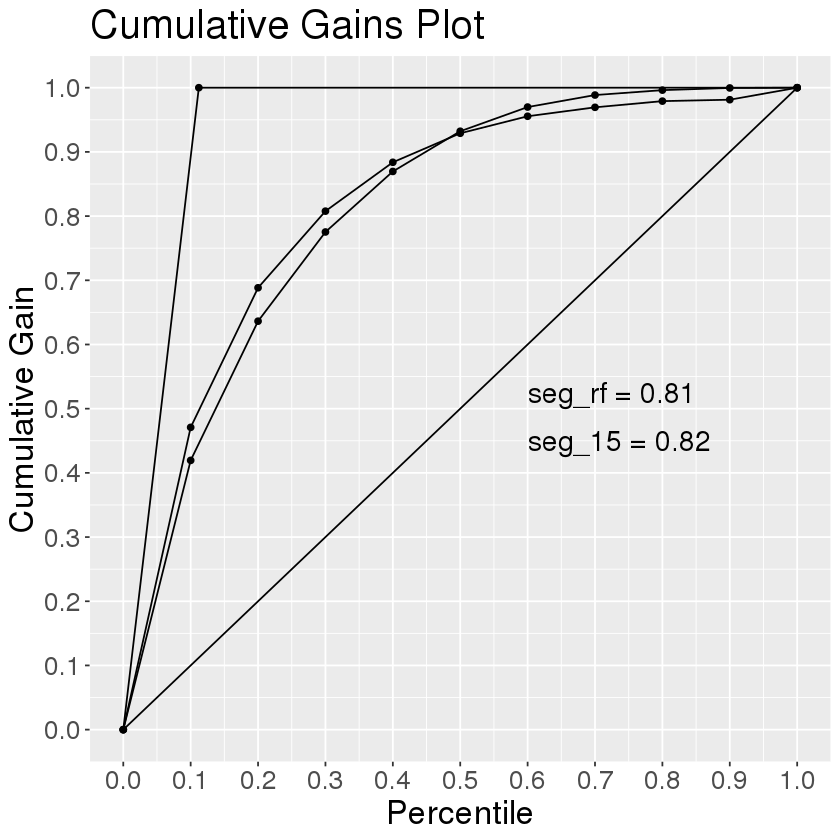

In [56]:
lift_df_seg_glm_expiry_exptest <- readRDS('../../data/lift_df_seg_glm_expiry_exptest')
plot_multigains <- plot_multigains(
    lift_df_list=list(
        seg_rf = lift_df,
        seg_15 = lift_df_seg_glm_expiry_exptest),
    auc_list = list(
        seg_rf= calc_auc(lift_df),
        seg_15= calc_auc(lift_df_seg_glm_expiry_exptest)))
# png(file = "../../data/output/plot_multigains_03_summ5.png",
#     width = 500, height = 375)
plot(plot_multigains)
# dev.off()

# top 100

In [57]:
top_tld_reg <- seg_glm_expiry_exptest %>% group_by(tld_registrar_index) %>% count() %>% arrange(desc(n)) %>% head(100) %>% select(n)
sum(top_tld_reg$n)

sum(top_tld_reg$n)/nrow(seg_glm_expiry_exptest)

tld_registrars = top_tld_reg$tld_registrar_index
tld_registrars

Adding missing grouping variables: `tld_registrar_index`



[1] 249947

[1] 0.842148

[1] "sitegmo"                       "funalibaba"                   
  [3] "sitenamecheap"                 "pwnamecheap"                  
  [5] "onlinego daddy"                "sitegandi sas"                
  [7] "sitereg.ru"                    "onlinenamecheap"              
  [9] "siteonlinenic"                 "hostnamecheap"                
 [11] "sitezhengzhou century connect" "funchengdu west"              
 [13] "spacego daddy"                 "websitenamecheap"             
 [15] "funnamecheap"                  "sitealibaba"                  
 [17] "onlinehostinger"               "spacenamecheap"               
 [19] "websiteuniregistrar"           "onlinealibaba"                
 [21] "onlinefbs"                     "sitego daddy"                 
 [23] "sitechengdu west"              "storealibaba"                 
 [25] "onlinechengdu west"            "storego daddy"                
 [27] "online1&1 internet"            "onlinedynadot"                
 [29] "pwgo daddy"                    "techhostinger"                
 [31] "spacereg.ru"                   "sitehostinger"                
 [33] "sitenetwork solutions"         "websitereg.ru"                
 [35] "funreg.ru"                     "onlinebigrock"                
 [37] "websitego daddy"               "pwgandi sas"                  
 [39] "storehostinger"                "techchengdu west"             
 [41] "sitefbs"                       "siteurl solutions"            
 [43] "onlinereg.ru"                  "storeshopify"                 
 [45] "onlineuniregistrar"            "onlineversio"                 
 [47] "techgo daddy"                  "funzhengzhou century connect" 
 [49] "spaceurl solutions"            "pwpdr ltd"                    
 [51] "sitedynadot"                   "pwdomains4bitcoins"           
 [53] "hostreg.ru"                    "onlineregister.it"            
 [55] "onlinepdr ltd"                 "techalibaba"                  
 [57] "in.netpdr ltd"                 "siteuniregistrar"             
 [59] "storenamecheap"                "onlineovh"                    
 [61] "technamecheap"                 "pwwest263 international"      
 [63] "onlinewix"                     "sitetenten"                   
 [65] "sitehostgator"                 "pwpdr china"                  
 [67] "fungo daddy"                   "onlinenamesilo"               
 [69] "hostgo daddy"                  "pressnamecheap"               
 [71] "onlineuol"                     "onlinesoluciones corporativas"
 [73] "sitenics telekom"              "storechengdu west"            
 [75] "onlineshanghai meicheng"       "spacehosting ukraine"         
 [77] "sitebeget"                     "spacegandi sas"               
 [79] "sitepdr china"                 "onlinegmo"                    
 [81] "websitegandi sas"              "pwwhois"                      
 [83] "storereg.ru"                   "sitehosting ukraine"          
 [85] "fungmo"                        "sitevalue domain"             
 [87] "spacegmo"                      "websitehostinger"             
 [89] "fundynadot"                    "onlinecronon ag"              
 [91] "fununiregistrar"               "onlinebluehost"               
 [93] "sitepdr ltd"                   "sitedotserve inc"             
 [95] "storewix"                      "onlinehome.pl"                
 [97] "websiteurl solutions"          "spacedynadot"                 
 [99] "onlineunited domains"          "onlineniaga hoster"

In [58]:
seg_glm_expiry_exptest_sub <- seg_glm_expiry_exptest %>% filter(tld_registrar_index %in% tld_registrars)

In [59]:
tld_registrars
num_trees = 1000
train = expiry_train_df_sub
test = expiry_test_df_sub


train$tld_registrar_index <- tolower(paste(train$tld,train$registrar,sep=""))
test$tld_registrar_index <- tolower(paste(test$tld,test$registrar,sep=""))

train <- train %>% filter(!(tld_registrar_index %in% tld_registrars))
test <- test %>% filter(!(tld_registrar_index %in% tld_registrars))

dim(train)/dim(expiry_train_df_sub)
head(train)

[1] "sitegmo"                       "funalibaba"                   
  [3] "sitenamecheap"                 "pwnamecheap"                  
  [5] "onlinego daddy"                "sitegandi sas"                
  [7] "sitereg.ru"                    "onlinenamecheap"              
  [9] "siteonlinenic"                 "hostnamecheap"                
 [11] "sitezhengzhou century connect" "funchengdu west"              
 [13] "spacego daddy"                 "websitenamecheap"             
 [15] "funnamecheap"                  "sitealibaba"                  
 [17] "onlinehostinger"               "spacenamecheap"               
 [19] "websiteuniregistrar"           "onlinealibaba"                
 [21] "onlinefbs"                     "sitego daddy"                 
 [23] "sitechengdu west"              "storealibaba"                 
 [25] "onlinechengdu west"            "storego daddy"                
 [27] "online1&1 internet"            "onlinedynadot"                
 [29] "pwgo daddy"                    "techhostinger"                
 [31] "spacereg.ru"                   "sitehostinger"                
 [33] "sitenetwork solutions"         "websitereg.ru"                
 [35] "funreg.ru"                     "onlinebigrock"                
 [37] "websitego daddy"               "pwgandi sas"                  
 [39] "storehostinger"                "techchengdu west"             
 [41] "sitefbs"                       "siteurl solutions"            
 [43] "onlinereg.ru"                  "storeshopify"                 
 [45] "onlineuniregistrar"            "onlineversio"                 
 [47] "techgo daddy"                  "funzhengzhou century connect" 
 [49] "spaceurl solutions"            "pwpdr ltd"                    
 [51] "sitedynadot"                   "pwdomains4bitcoins"           
 [53] "hostreg.ru"                    "onlineregister.it"            
 [55] "onlinepdr ltd"                 "techalibaba"                  
 [57] "in.netpdr ltd"                 "siteuniregistrar"             
 [59] "storenamecheap"                "onlineovh"                    
 [61] "technamecheap"                 "pwwest263 international"      
 [63] "onlinewix"                     "sitetenten"                   
 [65] "sitehostgator"                 "pwpdr china"                  
 [67] "fungo daddy"                   "onlinenamesilo"               
 [69] "hostgo daddy"                  "pressnamecheap"               
 [71] "onlineuol"                     "onlinesoluciones corporativas"
 [73] "sitenics telekom"              "storechengdu west"            
 [75] "onlineshanghai meicheng"       "spacehosting ukraine"         
 [77] "sitebeget"                     "spacegandi sas"               
 [79] "sitepdr china"                 "onlinegmo"                    
 [81] "websitegandi sas"              "pwwhois"                      
 [83] "storereg.ru"                   "sitehosting ukraine"          
 [85] "fungmo"                        "sitevalue domain"             
 [87] "spacegmo"                      "websitehostinger"             
 [89] "fundynadot"                    "onlinecronon ag"              
 [91] "fununiregistrar"               "onlinebluehost"               
 [93] "sitepdr ltd"                   "sitedotserve inc"             
 [95] "storewix"                      "onlinehome.pl"                
 [97] "websiteurl solutions"          "spacedynadot"                 
 [99] "onlineunited domains"          "onlineniaga hoster"

[1] 0.1598788 1.0833333

renewal_status,tld,registrar,reseller_country,region,reg_period,sld_type,sld_length,day_domains,gibb_score,pattern_domain_count,reg_arpt,tld_registrar_index
<fct>,<fct>,<chr>,<chr>,<chr>,<int>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<chr>
Renewed,fun,1&1 internet,Germany,Non China,1,l,7,1,6.77,1,15,fun1&1 internet
Renewed,fun,1&1 internet,Germany,Non China,1,ln,7,1,8.65,1,15,fun1&1 internet
Renewed,fun,1&1 internet,Germany,Non China,1,l,6,1,13.09,1,15,fun1&1 internet
Not Renewd,fun,1&1 internet,Germany,Non China,1,l,12,1,2.44,1,15,fun1&1 internet
Renewed,fun,1&1 internet,Germany,Non China,1,l,7,1,2.34,1,15,fun1&1 internet
Renewed,fun,1&1 internet,Germany,Non China,1,l,8,1,3.64,1,15,fun1&1 internet


In [60]:
cat("\nTraining & Testing remaining aggregate forest.\n")

ranger_03_reg <- ranger(
formula         = renewal_status ~ ., 
data            = train, 
importance      = 'impurity', 
num.trees       = num_trees,
    probability     = TRUE,
#     mtry            = 3,
#     min.node.size   = 10,
#     replace         = FALSE,
#     sample.fraction = .8,
seed            = 123
)

ranger_predict_03_reg <- predict(ranger_03_reg, 
                                 data = test,
                                 type="response")$predictions

ranger_predict_03_reg <- as.data.frame(ranger_predict_03_reg)$Renewed


Training & Testing remaining aggregate forest.
Growing trees.. Progress: 77%. Estimated remaining time: 9 seconds.


In [61]:
test$first_renewal_prediction <- ranger_predict_03_reg
head(test)

renewal_status,tld,registrar,reseller_country,region,reg_period,sld_type,sld_length,day_domains,gibb_score,pattern_domain_count,reg_arpt,tld_registrar_index,first_renewal_prediction
<fct>,<fct>,<chr>,<chr>,<chr>,<int>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<chr>,<dbl>
Renewed,fun,1&1 internet,Germany,Non China,1,l,6,1,2.23,1,15,fun1&1 internet,0.6450019
Renewed,fun,1&1 internet,Germany,Non China,1,l,9,1,3.45,1,15,fun1&1 internet,0.6621356
Not Renewd,fun,10dencehispahard,Spain,Non China,1,l,8,1,8.62,1,15,fun10dencehispahard,0.6389742
Not Renewd,fun,10dencehispahard,Spain,Non China,1,l,6,1,3.13,1,15,fun10dencehispahard,0.4983567
Renewed,fun,1api,Germany,Non China,1,l,7,1,4.51,1,5,fun1api,0.7914007
Not Renewd,fun,1api,Germany,Non China,1,l,7,1,6.09,1,5,fun1api,0.7937362


In [62]:
cols = names(test)
cols

[1] "renewal_status"           "tld"                     
 [3] "registrar"                "reseller_country"        
 [5] "region"                   "reg_period"              
 [7] "sld_type"                 "sld_length"              
 [9] "day_domains"              "gibb_score"              
[11] "pattern_domain_count"     "reg_arpt"                
[13] "tld_registrar_index"      "first_renewal_prediction"

In [63]:
dim(seg_glm_expiry_exptest_sub %>% select(all_of(cols)))

[1] 249947     14

In [64]:
dim(test)

[1] 47355    14

In [65]:
#992 rows missing - INVESTIGATE
agg_results = rbind(seg_glm_expiry_exptest_sub %>% select(all_of(cols)),test)
dim(agg_results)
dim(seg_glm_expiry_exptest)
dim(seg_glm_expiry_exptest)-dim(agg_results)
head(agg_results)

[1] 297302     14

[1] 296797     40

[1] -505   26

renewal_status,tld,registrar,reseller_country,region,reg_period,sld_type,sld_length,day_domains,gibb_score,pattern_domain_count,reg_arpt,tld_registrar_index,first_renewal_prediction
<fct>,<fct>,<chr>,<chr>,<chr>,<int>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<chr>,<dbl>
Not Renewd,fun,alibaba,China,China,2,l,6,1,3.81,1,4.75,funalibaba,0.3892428
Not Renewd,fun,alibaba,China,China,2,l,7,1,6.76,1,4.75,funalibaba,0.3677247
Renewed,fun,alibaba,China,China,2,l,7,1,0.97,1,4.75,funalibaba,0.3334929
Renewed,fun,alibaba,China,China,2,l,3,1,5.71,1,4.75,funalibaba,0.5258015
Not Renewd,fun,alibaba,China,China,2,n,5,1,100.00,1,4.75,funalibaba,0.4359649
Not Renewd,fun,alibaba,China,China,2,l,4,1,4.61,1,4.75,funalibaba,0.4766606


In [66]:
df = data.frame("actual" = agg_results$renewal_status,
          "predicted" = agg_results$first_renewal_prediction)

lift_df <- chart_lift(pred_df = df,
                        dep_var = "actual",
                        pred_var = "predicted")

gains_plot <- plot_gains (lift_df) 

auc_val <- calc_auc(lift_df)


# saveRDS(lift_df_seg_glm_expiry_exptest, file.path('../../data/output/',"lift_df_seg_glm_expiry_exptest"))

In [67]:
auc_val

[1] 0.8198313

In [68]:
lift_df

P,actu_renwd2,gain,lift
<dbl>,<int>,<dbl>,<dbl>
0.1,12068,0.4386450,4.386450
0.2,18166,0.6602937,3.301468
0.3,22108,0.8035766,2.678589
0.4,24532,0.8916836,2.229209
0.5,25966,0.9438063,1.887613
0.6,26823,0.9749564,1.624927
0.7,27218,0.9893138,1.413305
0.8,27425,0.9968377,1.246047
0.9,27490,0.9992003,1.110223


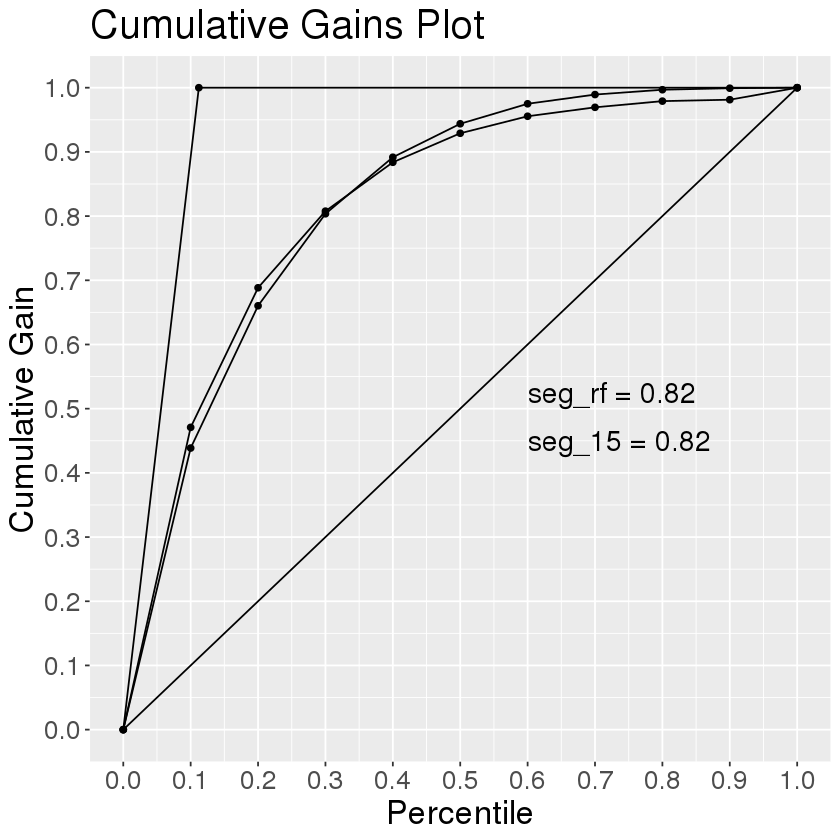

In [71]:
lift_df_seg_glm_expiry_exptest <- readRDS('../../data/lift_df_seg_glm_expiry_exptest')

source('functions_eval.R')

plot_multigains <- plot_multigains(
    lift_df_list=list(
        seg_rf = lift_df,
        seg_15 = lift_df_seg_glm_expiry_exptest),
    auc_list = list(
        seg_rf= calc_auc(lift_df),
        seg_15= calc_auc(lift_df_seg_glm_expiry_exptest)))
# png(file = "../../data/output/plot_multigains_03_summ5.png",
#     width = 500, height = 375)
plot(plot_multigains)
# dev.off()

In [72]:
calc_auc(lift_df)

[1] 0.8198313

In [73]:
calc_auc(lift_df_seg_glm_expiry_exptest)

[1] 0.8165071

In [74]:
lift_df

P,actu_renwd2,gain,lift
<dbl>,<int>,<dbl>,<dbl>
0.1,12068,0.4386450,4.386450
0.2,18166,0.6602937,3.301468
0.3,22108,0.8035766,2.678589
0.4,24532,0.8916836,2.229209
0.5,25966,0.9438063,1.887613
0.6,26823,0.9749564,1.624927
0.7,27218,0.9893138,1.413305
0.8,27425,0.9968377,1.246047
0.9,27490,0.9992003,1.110223


In [75]:
lift_df_seg_glm_expiry_exptest

P,actu_renwd2,gain,lift
<dbl>,<int>,<dbl>,<dbl>
0.1,12787,0.4708893,4.708893
0.2,18692,0.6883447,3.441723
0.3,21933,0.8076966,2.692322
0.4,24000,0.8838151,2.209538
0.5,25227,0.9290002,1.858000
0.6,25947,0.9555146,1.592524
0.7,26325,0.9694347,1.384907
0.8,26587,0.9790830,1.223854
0.9,26647,0.9812926,1.090325


# top 100 - reweighted

In [76]:
top_tld_reg <- seg_glm_expiry_exptest %>% group_by(tld_registrar_index) %>% count() %>% arrange(desc(n)) %>% head(100) %>% select(n)
sum(top_tld_reg$n)

sum(top_tld_reg$n)/nrow(seg_glm_expiry_exptest)

tld_registrars = top_tld_reg$tld_registrar_index
tld_registrars

Adding missing grouping variables: `tld_registrar_index`



[1] 249947

[1] 0.842148

[1] "sitegmo"                       "funalibaba"                   
  [3] "sitenamecheap"                 "pwnamecheap"                  
  [5] "onlinego daddy"                "sitegandi sas"                
  [7] "sitereg.ru"                    "onlinenamecheap"              
  [9] "siteonlinenic"                 "hostnamecheap"                
 [11] "sitezhengzhou century connect" "funchengdu west"              
 [13] "spacego daddy"                 "websitenamecheap"             
 [15] "funnamecheap"                  "sitealibaba"                  
 [17] "onlinehostinger"               "spacenamecheap"               
 [19] "websiteuniregistrar"           "onlinealibaba"                
 [21] "onlinefbs"                     "sitego daddy"                 
 [23] "sitechengdu west"              "storealibaba"                 
 [25] "onlinechengdu west"            "storego daddy"                
 [27] "online1&1 internet"            "onlinedynadot"                
 [29] "pwgo daddy"                    "techhostinger"                
 [31] "spacereg.ru"                   "sitehostinger"                
 [33] "sitenetwork solutions"         "websitereg.ru"                
 [35] "funreg.ru"                     "onlinebigrock"                
 [37] "websitego daddy"               "pwgandi sas"                  
 [39] "storehostinger"                "techchengdu west"             
 [41] "sitefbs"                       "siteurl solutions"            
 [43] "onlinereg.ru"                  "storeshopify"                 
 [45] "onlineuniregistrar"            "onlineversio"                 
 [47] "techgo daddy"                  "funzhengzhou century connect" 
 [49] "spaceurl solutions"            "pwpdr ltd"                    
 [51] "sitedynadot"                   "pwdomains4bitcoins"           
 [53] "hostreg.ru"                    "onlineregister.it"            
 [55] "onlinepdr ltd"                 "techalibaba"                  
 [57] "in.netpdr ltd"                 "siteuniregistrar"             
 [59] "storenamecheap"                "onlineovh"                    
 [61] "technamecheap"                 "pwwest263 international"      
 [63] "onlinewix"                     "sitetenten"                   
 [65] "sitehostgator"                 "pwpdr china"                  
 [67] "fungo daddy"                   "onlinenamesilo"               
 [69] "hostgo daddy"                  "pressnamecheap"               
 [71] "onlineuol"                     "onlinesoluciones corporativas"
 [73] "sitenics telekom"              "storechengdu west"            
 [75] "onlineshanghai meicheng"       "spacehosting ukraine"         
 [77] "sitebeget"                     "spacegandi sas"               
 [79] "sitepdr china"                 "onlinegmo"                    
 [81] "websitegandi sas"              "pwwhois"                      
 [83] "storereg.ru"                   "sitehosting ukraine"          
 [85] "fungmo"                        "sitevalue domain"             
 [87] "spacegmo"                      "websitehostinger"             
 [89] "fundynadot"                    "onlinecronon ag"              
 [91] "fununiregistrar"               "onlinebluehost"               
 [93] "sitepdr ltd"                   "sitedotserve inc"             
 [95] "storewix"                      "onlinehome.pl"                
 [97] "websiteurl solutions"          "spacedynadot"                 
 [99] "onlineunited domains"          "onlineniaga hoster"

In [77]:
seg_glm_expiry_exptest_sub <- seg_glm_expiry_exptest %>% filter(tld_registrar_index %in% tld_registrars)

In [78]:
tld_registrars
num_trees = 1000
train = expiry_train_df_sub
test = expiry_test_df_sub


train$tld_registrar_index <- tolower(paste(train$tld,train$registrar,sep=""))
test$tld_registrar_index <- tolower(paste(test$tld,test$registrar,sep=""))

train <- train %>% filter(!(tld_registrar_index %in% tld_registrars))
test <- test %>% filter(!(tld_registrar_index %in% tld_registrars))

dim(train)/dim(expiry_train_df_sub)
head(train)

[1] "sitegmo"                       "funalibaba"                   
  [3] "sitenamecheap"                 "pwnamecheap"                  
  [5] "onlinego daddy"                "sitegandi sas"                
  [7] "sitereg.ru"                    "onlinenamecheap"              
  [9] "siteonlinenic"                 "hostnamecheap"                
 [11] "sitezhengzhou century connect" "funchengdu west"              
 [13] "spacego daddy"                 "websitenamecheap"             
 [15] "funnamecheap"                  "sitealibaba"                  
 [17] "onlinehostinger"               "spacenamecheap"               
 [19] "websiteuniregistrar"           "onlinealibaba"                
 [21] "onlinefbs"                     "sitego daddy"                 
 [23] "sitechengdu west"              "storealibaba"                 
 [25] "onlinechengdu west"            "storego daddy"                
 [27] "online1&1 internet"            "onlinedynadot"                
 [29] "pwgo daddy"                    "techhostinger"                
 [31] "spacereg.ru"                   "sitehostinger"                
 [33] "sitenetwork solutions"         "websitereg.ru"                
 [35] "funreg.ru"                     "onlinebigrock"                
 [37] "websitego daddy"               "pwgandi sas"                  
 [39] "storehostinger"                "techchengdu west"             
 [41] "sitefbs"                       "siteurl solutions"            
 [43] "onlinereg.ru"                  "storeshopify"                 
 [45] "onlineuniregistrar"            "onlineversio"                 
 [47] "techgo daddy"                  "funzhengzhou century connect" 
 [49] "spaceurl solutions"            "pwpdr ltd"                    
 [51] "sitedynadot"                   "pwdomains4bitcoins"           
 [53] "hostreg.ru"                    "onlineregister.it"            
 [55] "onlinepdr ltd"                 "techalibaba"                  
 [57] "in.netpdr ltd"                 "siteuniregistrar"             
 [59] "storenamecheap"                "onlineovh"                    
 [61] "technamecheap"                 "pwwest263 international"      
 [63] "onlinewix"                     "sitetenten"                   
 [65] "sitehostgator"                 "pwpdr china"                  
 [67] "fungo daddy"                   "onlinenamesilo"               
 [69] "hostgo daddy"                  "pressnamecheap"               
 [71] "onlineuol"                     "onlinesoluciones corporativas"
 [73] "sitenics telekom"              "storechengdu west"            
 [75] "onlineshanghai meicheng"       "spacehosting ukraine"         
 [77] "sitebeget"                     "spacegandi sas"               
 [79] "sitepdr china"                 "onlinegmo"                    
 [81] "websitegandi sas"              "pwwhois"                      
 [83] "storereg.ru"                   "sitehosting ukraine"          
 [85] "fungmo"                        "sitevalue domain"             
 [87] "spacegmo"                      "websitehostinger"             
 [89] "fundynadot"                    "onlinecronon ag"              
 [91] "fununiregistrar"               "onlinebluehost"               
 [93] "sitepdr ltd"                   "sitedotserve inc"             
 [95] "storewix"                      "onlinehome.pl"                
 [97] "websiteurl solutions"          "spacedynadot"                 
 [99] "onlineunited domains"          "onlineniaga hoster"

[1] 0.1598788 1.0833333

renewal_status,tld,registrar,reseller_country,region,reg_period,sld_type,sld_length,day_domains,gibb_score,pattern_domain_count,reg_arpt,tld_registrar_index
<fct>,<fct>,<chr>,<chr>,<chr>,<int>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<chr>
Renewed,fun,1&1 internet,Germany,Non China,1,l,7,1,6.77,1,15,fun1&1 internet
Renewed,fun,1&1 internet,Germany,Non China,1,ln,7,1,8.65,1,15,fun1&1 internet
Renewed,fun,1&1 internet,Germany,Non China,1,l,6,1,13.09,1,15,fun1&1 internet
Not Renewd,fun,1&1 internet,Germany,Non China,1,l,12,1,2.44,1,15,fun1&1 internet
Renewed,fun,1&1 internet,Germany,Non China,1,l,7,1,2.34,1,15,fun1&1 internet
Renewed,fun,1&1 internet,Germany,Non China,1,l,8,1,3.64,1,15,fun1&1 internet


In [80]:
# reweight
# for smote/rose sampling
library(DMwR)
library(ROSE)
require("plyr")


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loaded ROSE 0.0-3


Loading required package: plyr

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following object is masked from ‘package:DMwR’:

    join


The following objects are masked from ‘package:plotly’:

    arrange, mutate, rename, summarise


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize




In [84]:
str(train)

Classes ‘data.table’ and 'data.frame':	189976 obs. of  13 variables:
 $ renewal_status      : Factor w/ 2 levels "Not Renewd","Renewed": 2 2 2 1 2 2 2 1 2 2 ...
 $ tld                 : Factor w/ 11 levels "fun","host","in.net",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ registrar           : chr  "1&1 internet" "1&1 internet" "1&1 internet" "1&1 internet" ...
 $ reseller_country    : chr  "Germany" "Germany" "Germany" "Germany" ...
 $ region              : chr  "Non China" "Non China" "Non China" "Non China" ...
 $ reg_period          : int  1 1 1 1 1 1 1 1 1 1 ...
 $ sld_type            : Factor w/ 6 levels "hyphen-l","l",..: 2 3 2 2 2 2 3 2 1 2 ...
 $ sld_length          : int  7 7 6 12 7 8 12 6 14 5 ...
 $ day_domains         : int  1 1 1 1 1 1 1 1 1 2 ...
 $ gibb_score          : num  6.77 8.65 13.09 2.44 2.34 ...
 $ pattern_domain_count: int  1 1 1 1 1 1 1 1 1 1 ...
 $ reg_arpt            : num  15 15 15 15 15 15 15 15 15 15 ...
 $ tld_registrar_index : chr  "fun1&1 internet" "fun1&1 internet

In [81]:
# # SMOTE
# tr_smote <- SMOTE(renewal_status ~ ., data  = train)                         

# dim(tr_smote)
# prop.table(table(tr_smote$renewal_status))

Warning message in smote.exs(data[minExs, ], ncol(data), perc.over, k):
“NAs introduced by coercion”
Warning message in smote.exs(data[minExs, ], ncol(data), perc.over, k):
“NAs introduced by coercion”
Warning message in smote.exs(data[minExs, ], ncol(data), perc.over, k):
“NAs introduced by coercion”
Warning message in smote.exs(data[minExs, ], ncol(data), perc.over, k):
“NAs introduced by coercion”


ERROR: Error in factor(newCases[, a], levels = 1:nlevels(data[, a]), labels = levels(data[, : invalid 'labels'; length 0 should be 1 or 2


In [85]:
# upsamples
tr_u <- upSample(x = train %>% select(-renewal_status),
                   y = train$renewal_status)
dim(tr_u)
prop.table(table(tr_u$Class))

[1] 286298     13


Not Renewd    Renewed 
       0.5        0.5 

In [86]:
cat("\nTraining & Testing remaining aggregate forest.\n")

ranger_03_reg_u <- ranger(
formula         = Class ~ ., 
data            = tr_u, 
importance      = 'impurity', 
num.trees       = num_trees,
    probability     = TRUE,
#     mtry            = 3,
#     min.node.size   = 10,
#     replace         = FALSE,
#     sample.fraction = .8,
seed            = 123
)

ranger_predict_03_reg_u <- predict(ranger_03_reg_u, 
                                 data = test,
                                 type="response")$predictions

ranger_predict_03_reg_u <- as.data.frame(ranger_predict_03_reg_u)$Renewed


Training & Testing remaining aggregate forest.
Growing trees.. Progress: 38%. Estimated remaining time: 50 seconds.
Growing trees.. Progress: 77%. Estimated remaining time: 19 seconds.


In [135]:
ranger_03_reg_u

Ranger result

Call:
 ranger(formula = Class ~ ., data = tr_u, importance = "impurity",      num.trees = num_trees, probability = TRUE, seed = 123) 

Type:                             Probability estimation 
Number of trees:                  1000 
Sample size:                      286298 
Number of independent variables:  12 
Mtry:                             3 
Target node size:                 10 
Variable importance mode:         impurity 
Splitrule:                        gini 
OOB prediction error (Brier s.):  0.12789 

In [136]:
test$first_renewal_prediction <- ranger_predict_03_reg_u
head(test)

renewal_status,tld,registrar,reseller_country,region,reg_period,sld_type,sld_length,day_domains,gibb_score,pattern_domain_count,reg_arpt,tld_registrar_index,first_renewal_prediction
<fct>,<fct>,<chr>,<chr>,<chr>,<int>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<chr>,<dbl>
Renewed,fun,1&1 internet,Germany,Non China,1,l,6,1,2.23,1,15,fun1&1 internet,0.7572870
Renewed,fun,1&1 internet,Germany,Non China,1,l,9,1,3.45,1,15,fun1&1 internet,0.7584753
Not Renewd,fun,10dencehispahard,Spain,Non China,1,l,8,1,8.62,1,15,fun10dencehispahard,0.6885058
Not Renewd,fun,10dencehispahard,Spain,Non China,1,l,6,1,3.13,1,15,fun10dencehispahard,0.5500143
Renewed,fun,1api,Germany,Non China,1,l,7,1,4.51,1,5,fun1api,0.8509584
Not Renewd,fun,1api,Germany,Non China,1,l,7,1,6.09,1,5,fun1api,0.8377688


In [137]:
cols = names(test)
cols

[1] "renewal_status"           "tld"                     
 [3] "registrar"                "reseller_country"        
 [5] "region"                   "reg_period"              
 [7] "sld_type"                 "sld_length"              
 [9] "day_domains"              "gibb_score"              
[11] "pattern_domain_count"     "reg_arpt"                
[13] "tld_registrar_index"      "first_renewal_prediction"

In [138]:
dim(seg_glm_expiry_exptest_sub %>% select(all_of(cols)))

[1] 249947     14

In [139]:
dim(test)

[1] 47355    14

In [141]:
#505 additional rows upsample
agg_results = rbind(seg_glm_expiry_exptest_sub %>% select(all_of(cols)),test)
dim(agg_results)
dim(seg_glm_expiry_exptest)
dim(seg_glm_expiry_exptest)-dim(agg_results)
head(agg_results)

[1] 297302     14

[1] 296797     40

[1] -505   26

renewal_status,tld,registrar,reseller_country,region,reg_period,sld_type,sld_length,day_domains,gibb_score,pattern_domain_count,reg_arpt,tld_registrar_index,first_renewal_prediction
<fct>,<fct>,<chr>,<chr>,<chr>,<int>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<chr>,<dbl>
Not Renewd,fun,alibaba,China,China,2,l,6,1,3.81,1,4.75,funalibaba,0.3892428
Not Renewd,fun,alibaba,China,China,2,l,7,1,6.76,1,4.75,funalibaba,0.3677247
Renewed,fun,alibaba,China,China,2,l,7,1,0.97,1,4.75,funalibaba,0.3334929
Renewed,fun,alibaba,China,China,2,l,3,1,5.71,1,4.75,funalibaba,0.5258015
Not Renewd,fun,alibaba,China,China,2,n,5,1,100.00,1,4.75,funalibaba,0.4359649
Not Renewd,fun,alibaba,China,China,2,l,4,1,4.61,1,4.75,funalibaba,0.4766606


In [142]:
df = data.frame("actual" = agg_results$renewal_status,
          "predicted" = agg_results$first_renewal_prediction)

lift_df <- chart_lift(pred_df = df,
                        dep_var = "actual",
                        pred_var = "predicted")

gains_plot <- plot_gains (lift_df) 

auc_val <- calc_auc(lift_df)


# saveRDS(lift_df_seg_glm_expiry_exptest, file.path('../../data/output/',"lift_df_seg_glm_expiry_exptest"))

In [143]:
auc_val

[1] 0.8182611

In [144]:
lift_df

P,actu_renwd2,gain,lift
<dbl>,<int>,<dbl>,<dbl>
0.1,11986,0.4356644,4.356644
0.2,17929,0.6516793,3.258396
0.3,22025,0.8005598,2.668533
0.4,24508,0.8908113,2.227028
0.5,25961,0.9436246,1.887249
0.6,26823,0.9749564,1.624927
0.7,27217,0.9892774,1.413253
0.8,27425,0.9968377,1.246047
0.9,27490,0.9992003,1.110223


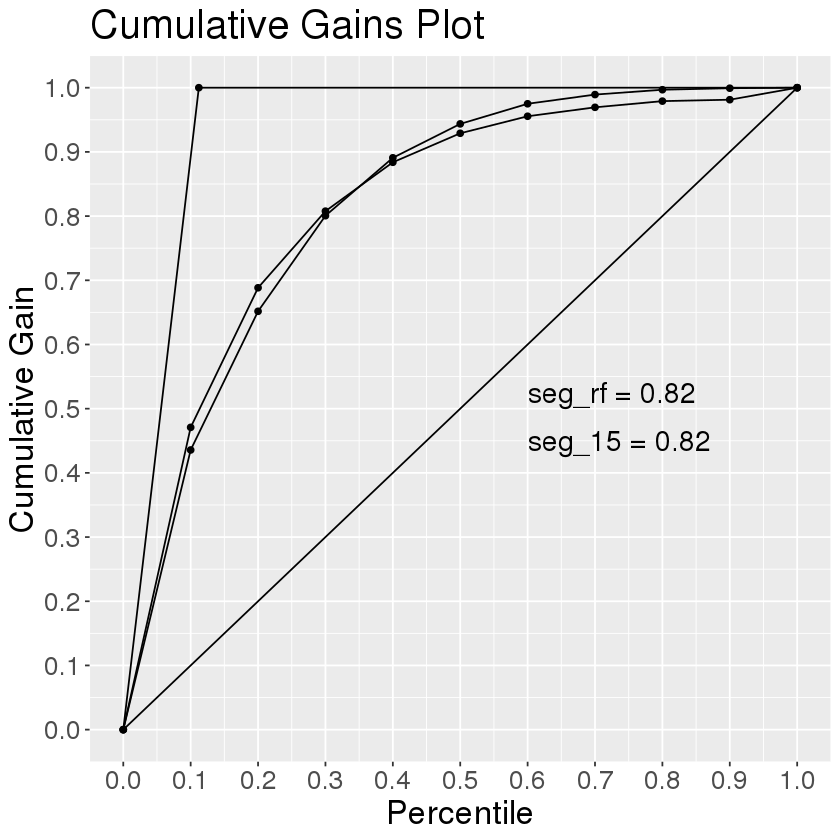

In [110]:
lift_df_seg_glm_expiry_exptest <- readRDS('../../data/lift_df_seg_glm_expiry_exptest')

source('functions_eval.R')

plot_multigains <- plot_multigains(
    lift_df_list=list(
        seg_rf = lift_df,
        seg_15 = lift_df_seg_glm_expiry_exptest),
    auc_list = list(
        seg_rf= calc_auc(lift_df),
        seg_15= calc_auc(lift_df_seg_glm_expiry_exptest)))
# png(file = "../../data/output/plot_multigains_03_summ5.png",
#     width = 500, height = 375)
plot(plot_multigains)
# dev.off()

In [145]:
calc_auc(lift_df)

[1] 0.8182611

In [146]:
calc_auc(lift_df_seg_glm_expiry_exptest)

[1] 0.8165071

In [147]:
lift_df

P,actu_renwd2,gain,lift
<dbl>,<int>,<dbl>,<dbl>
0.1,11986,0.4356644,4.356644
0.2,17929,0.6516793,3.258396
0.3,22025,0.8005598,2.668533
0.4,24508,0.8908113,2.227028
0.5,25961,0.9436246,1.887249
0.6,26823,0.9749564,1.624927
0.7,27217,0.9892774,1.413253
0.8,27425,0.9968377,1.246047
0.9,27490,0.9992003,1.110223


In [101]:
lift_df_seg_glm_expiry_exptest

P,actu_renwd2,gain,lift
<dbl>,<int>,<dbl>,<dbl>
0.1,12787,0.4708893,4.708893
0.2,18692,0.6883447,3.441723
0.3,21933,0.8076966,2.692322
0.4,24000,0.8838151,2.209538
0.5,25227,0.9290002,1.858000
0.6,25947,0.9555146,1.592524
0.7,26325,0.9694347,1.384907
0.8,26587,0.9790830,1.223854
0.9,26647,0.9812926,1.090325


# top 100 - smote

In [111]:
top_tld_reg <- seg_glm_expiry_exptest %>% group_by(tld_registrar_index) %>% count() %>% arrange(desc(n)) %>% head(100) %>% select(n)
sum(top_tld_reg$n)

sum(top_tld_reg$n)/nrow(seg_glm_expiry_exptest)

tld_registrars = top_tld_reg$tld_registrar_index
tld_registrars

Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'closure'”


ERROR: Error in x[!nas]: object of type 'closure' is not subsettable


In [ ]:
seg_glm_expiry_exptest_sub <- seg_glm_expiry_exptest %>% filter(tld_registrar_index %in% tld_registrars)

In [ ]:
tld_registrars
num_trees = 1000
train = expiry_train_df_sub
test = expiry_test_df_sub


train$tld_registrar_index <- tolower(paste(train$tld,train$registrar,sep=""))
test$tld_registrar_index <- tolower(paste(test$tld,test$registrar,sep=""))

train <- train %>% filter(!(tld_registrar_index %in% tld_registrars))
test <- test %>% filter(!(tld_registrar_index %in% tld_registrars))

dim(train)/dim(expiry_train_df_sub)
head(train)

In [ ]:
# reweight
# for smote/rose sampling
library(DMwR)
library(ROSE)
require("plyr")


In [114]:
# convert any character vars to factors
tr <- train %>%
  mutate_if(sapply(train, is.character), as.factor)

# create valid factor names for registrar 
# tr$registrar <- mapvalues(tr$registrar, levels(tr$registrar), make.names(levels(tr$registrar), unique=TRUE))
# tr <- tr %>% 
#   mutate(registrar = factor(registrar, 
#                         labels = make.names(levels(registrar))))
tr <- tr %>% 
  mutate(renewal_status = factor(renewal_status, 
                        labels = make.names(levels(renewal_status))))
tr <- tr %>% 
  mutate(tld = factor(tld, 
                        labels = make.names(levels(tld))))
tr <- tr %>% 
  mutate(reseller_country = factor(reseller_country, 
                        labels = make.names(levels(reseller_country))))
tr <- tr %>% 
  mutate(region = factor(region, 
                        labels = make.names(levels(region))))
tr <- tr %>% 
  mutate(sld_type = factor(sld_type, 
                        labels = make.names(levels(sld_type))))

In [116]:
str(tr)

Classes ‘data.table’ and 'data.frame':	189976 obs. of  13 variables:
 $ renewal_status      : Factor w/ 2 levels "Not.Renewd","Renewed": 2 2 2 1 2 2 2 1 2 2 ...
 $ tld                 : Factor w/ 11 levels "fun","host","in.net",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ registrar           : Factor w/ 176 levels "1&1 internet",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ reseller_country    : Factor w/ 57 levels "X","Argentina",..: 18 18 18 18 18 18 18 18 18 18 ...
 $ region              : Factor w/ 2 levels "China","Non.China": 2 2 2 2 2 2 2 2 2 2 ...
 $ reg_period          : int  1 1 1 1 1 1 1 1 1 1 ...
 $ sld_type            : Factor w/ 6 levels "hyphen.l","l",..: 2 3 2 2 2 2 3 2 1 2 ...
 $ sld_length          : int  7 7 6 12 7 8 12 6 14 5 ...
 $ day_domains         : int  1 1 1 1 1 1 1 1 1 2 ...
 $ gibb_score          : num  6.77 8.65 13.09 2.44 2.34 ...
 $ pattern_domain_count: int  1 1 1 1 1 1 1 1 1 1 ...
 $ reg_arpt            : num  15 15 15 15 15 15 15 15 15 15 ...
 $ tld_registrar_index : Factor w/ 95

In [117]:
# SMOTE
tr_smote <- SMOTE(renewal_status ~ ., data  = tr)                         

dim(tr_smote)
prop.table(table(tr_smote$renewal_status))

[1] 327789     13


Not.Renewd    Renewed 
 0.5714286  0.4285714 

In [85]:
# # upsamples
# tr_u <- upSample(x = train %>% select(-renewal_status),
#                    y = train$renewal_status)
# dim(tr_u)
# prop.table(table(tr_u$Class))

[1] 286298     13


Not Renewd    Renewed 
       0.5        0.5 

In [119]:
cat("\nTraining & Testing remaining aggregate forest.\n")

ranger_03_reg_smote <- ranger(
formula         = renewal_status ~ ., 
data            = tr_smote, 
importance      = 'impurity', 
num.trees       = num_trees,
    probability     = TRUE,
#     mtry            = 3,
#     min.node.size   = 10,
#     replace         = FALSE,
#     sample.fraction = .8,
seed            = 123
)

ranger_predict_03_reg_smote <- predict(ranger_03_reg_smote, 
                                 data = test,
                                 type="response")$predictions

ranger_predict_03_reg_smote <- as.data.frame(ranger_predict_03_reg_smote)$Renewed


Training & Testing remaining aggregate forest.
Growing trees.. Progress: 17%. Estimated remaining time: 2 minutes, 34 seconds.
Growing trees.. Progress: 34%. Estimated remaining time: 2 minutes, 1 seconds.
Growing trees.. Progress: 51%. Estimated remaining time: 1 minute, 30 seconds.
Growing trees.. Progress: 68%. Estimated remaining time: 58 seconds.
Growing trees.. Progress: 85%. Estimated remaining time: 26 seconds.


In [121]:
ranger_03_reg_smote

Ranger result

Call:
 ranger(formula = renewal_status ~ ., data = tr_smote, importance = "impurity",      num.trees = num_trees, probability = TRUE, seed = 123) 

Type:                             Probability estimation 
Number of trees:                  1000 
Sample size:                      327789 
Number of independent variables:  12 
Mtry:                             3 
Target node size:                 10 
Variable importance mode:         impurity 
Splitrule:                        gini 
OOB prediction error (Brier s.):  0.08026643 

In [122]:
test$first_renewal_prediction <- ranger_predict_03_reg_smote
head(test)

renewal_status,tld,registrar,reseller_country,region,reg_period,sld_type,sld_length,day_domains,gibb_score,pattern_domain_count,reg_arpt,tld_registrar_index,first_renewal_prediction
<fct>,<fct>,<chr>,<chr>,<chr>,<int>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<chr>,<dbl>
Renewed,fun,1&1 internet,Germany,Non China,1,l,6,1,2.23,1,15,fun1&1 internet,0.6955918
Renewed,fun,1&1 internet,Germany,Non China,1,l,9,1,3.45,1,15,fun1&1 internet,0.6624071
Not Renewd,fun,10dencehispahard,Spain,Non China,1,l,8,1,8.62,1,15,fun10dencehispahard,0.7011924
Not Renewd,fun,10dencehispahard,Spain,Non China,1,l,6,1,3.13,1,15,fun10dencehispahard,0.6678160
Renewed,fun,1api,Germany,Non China,1,l,7,1,4.51,1,5,fun1api,0.8254769
Not Renewd,fun,1api,Germany,Non China,1,l,7,1,6.09,1,5,fun1api,0.8335500


In [123]:
cols = names(test)
cols

[1] "renewal_status"           "tld"                     
 [3] "registrar"                "reseller_country"        
 [5] "region"                   "reg_period"              
 [7] "sld_type"                 "sld_length"              
 [9] "day_domains"              "gibb_score"              
[11] "pattern_domain_count"     "reg_arpt"                
[13] "tld_registrar_index"      "first_renewal_prediction"

In [124]:
dim(seg_glm_expiry_exptest_sub %>% select(all_of(cols)))

[1] 249947     14

In [125]:
dim(test)

[1] 47355    14

In [126]:
#505 additional rows upsample
agg_results = rbind(seg_glm_expiry_exptest_sub %>% select(all_of(cols)),test)
dim(agg_results)
dim(seg_glm_expiry_exptest)
dim(seg_glm_expiry_exptest)-dim(agg_results)
head(agg_results)

[1] 297302     14

[1] 296797     40

[1] -505   26

renewal_status,tld,registrar,reseller_country,region,reg_period,sld_type,sld_length,day_domains,gibb_score,pattern_domain_count,reg_arpt,tld_registrar_index,first_renewal_prediction
<fct>,<fct>,<chr>,<chr>,<chr>,<int>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<chr>,<dbl>
Not Renewd,fun,alibaba,China,China,2,l,6,1,3.81,1,4.75,funalibaba,0.3892428
Not Renewd,fun,alibaba,China,China,2,l,7,1,6.76,1,4.75,funalibaba,0.3677247
Renewed,fun,alibaba,China,China,2,l,7,1,0.97,1,4.75,funalibaba,0.3334929
Renewed,fun,alibaba,China,China,2,l,3,1,5.71,1,4.75,funalibaba,0.5258015
Not Renewd,fun,alibaba,China,China,2,n,5,1,100.00,1,4.75,funalibaba,0.4359649
Not Renewd,fun,alibaba,China,China,2,l,4,1,4.61,1,4.75,funalibaba,0.4766606


In [127]:
df = data.frame("actual" = agg_results$renewal_status,
          "predicted" = agg_results$first_renewal_prediction)

lift_df <- chart_lift(pred_df = df,
                        dep_var = "actual",
                        pred_var = "predicted")

gains_plot <- plot_gains (lift_df) 

auc_val <- calc_auc(lift_df)


# saveRDS(lift_df_seg_glm_expiry_exptest, file.path('../../data/output/',"lift_df_seg_glm_expiry_exptest"))

In [128]:
auc_val

[1] 0.8064808

In [129]:
lift_df

P,actu_renwd2,gain,lift
<dbl>,<int>,<dbl>,<dbl>
0.1,9969,0.3623510,3.623510
0.2,17032,0.6190753,3.095377
0.3,21800,0.7923815,2.641272
0.4,24439,0.8883033,2.220758
0.5,25934,0.9426432,1.885286
0.6,26817,0.9747383,1.624564
0.7,27217,0.9892774,1.413253
0.8,27425,0.9968377,1.246047
0.9,27490,0.9992003,1.110223


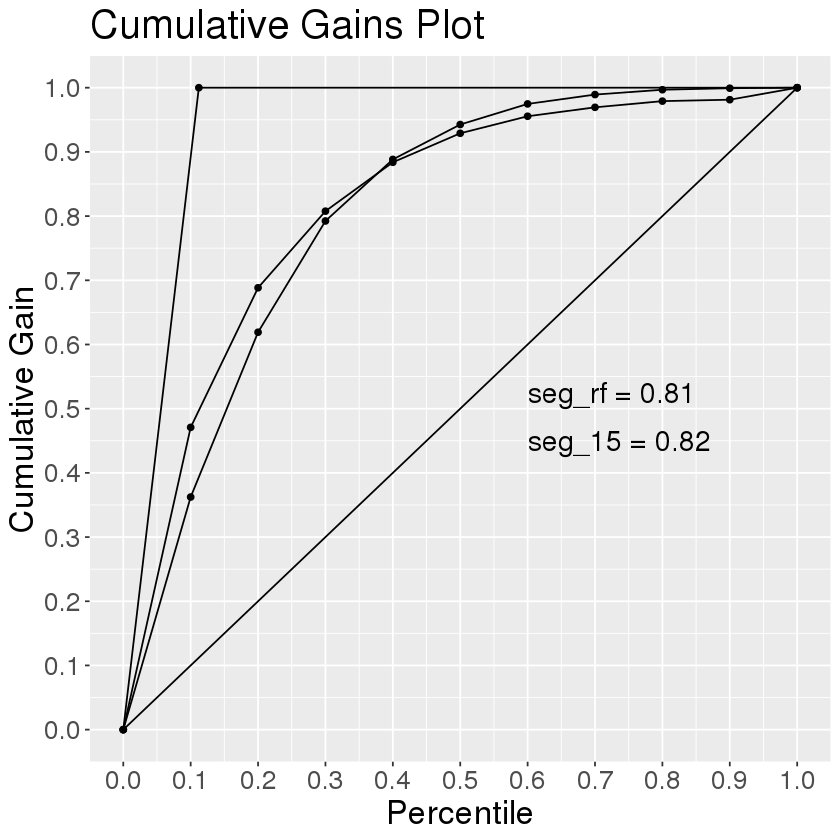

In [130]:
lift_df_seg_glm_expiry_exptest <- readRDS('../../data/lift_df_seg_glm_expiry_exptest')

source('functions_eval.R')

plot_multigains <- plot_multigains(
    lift_df_list=list(
        seg_rf = lift_df,
        seg_15 = lift_df_seg_glm_expiry_exptest),
    auc_list = list(
        seg_rf= calc_auc(lift_df),
        seg_15= calc_auc(lift_df_seg_glm_expiry_exptest)))
# png(file = "../../data/output/plot_multigains_03_summ5.png",
#     width = 500, height = 375)
plot(plot_multigains)
# dev.off()

In [131]:
calc_auc(lift_df)

[1] 0.8064808

In [132]:
calc_auc(lift_df_seg_glm_expiry_exptest)

[1] 0.8165071

In [133]:
lift_df

P,actu_renwd2,gain,lift
<dbl>,<int>,<dbl>,<dbl>
0.1,9969,0.3623510,3.623510
0.2,17032,0.6190753,3.095377
0.3,21800,0.7923815,2.641272
0.4,24439,0.8883033,2.220758
0.5,25934,0.9426432,1.885286
0.6,26817,0.9747383,1.624564
0.7,27217,0.9892774,1.413253
0.8,27425,0.9968377,1.246047
0.9,27490,0.9992003,1.110223


In [134]:
lift_df_seg_glm_expiry_exptest

P,actu_renwd2,gain,lift
<dbl>,<int>,<dbl>,<dbl>
0.1,12787,0.4708893,4.708893
0.2,18692,0.6883447,3.441723
0.3,21933,0.8076966,2.692322
0.4,24000,0.8838151,2.209538
0.5,25227,0.9290002,1.858000
0.6,25947,0.9555146,1.592524
0.7,26325,0.9694347,1.384907
0.8,26587,0.9790830,1.223854
0.9,26647,0.9812926,1.090325


# top 150

In [155]:
filename = 'seg_glm_expiry_exptest'
system(paste(sprintf("gsutil cp gs://data_input/%s /home/jupyter/local/Domains_202003/data/", filename)))
seg_glm_expiry_exptest <- readRDS(file.path("/home/jupyter/local/Domains_202003/data/", filename))

In [156]:
head(seg_glm_expiry_exptest)

renewal_type,renewed_count,expiry_date,domain_id,domain,creation_date,status,tld,registrar,reseller,⋯,sld_length,sld_type2,day_domains,log_reg_arpt,gibb_score,pattern,cluster,pattern_score,pattern_domain_count,first_renewal_prediction
<chr>,<int>,<date>,<int>,<chr>,<date>,<chr>,<fct>,<chr>,<chr>,⋯,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>
FirstTime,1,2020-01-22,91639803,segeln.fun,2019-01-22,Active,fun,1&1 internet,1&1 internet,⋯,6,6l,1,2.708050,2.23,segeln,1,1,1,0.8459141
FirstTime,1,2020-03-07,95819759,harzhotel.fun,2019-03-07,Active,fun,1&1 internet,1&1 internet,⋯,9,9l,1,2.708050,3.45,harzhotel,1,1,1,0.4607455
FirstTime,1,2020-01-15,91044973,movistar.fun,2019-01-15,Active,fun,10dencehispahard,10dencehispahard,⋯,8,8l,1,2.708050,8.62,movistar,1,1,1,NA
FirstTime,1,2020-02-01,92472913,kuinik.fun,2019-02-01,Active,fun,10dencehispahard,10dencehispahard,⋯,6,6l,1,2.708050,3.13,kuinik,1,1,1,NA
FirstTime,1,2020-01-21,91532433,bulgari.fun,2019-01-21,Active,fun,1api,1api,⋯,7,7l,1,1.609438,4.51,bulgari,1,1,1,0.9999971
FirstTime,1,2020-04-24,101717674,gotsome.fun,2019-04-24,Active,fun,1api,1api,⋯,7,7l,1,1.609438,6.09,gotsome,1,1,1,0.9999992


In [168]:
top_tld_reg <- seg_glm_expiry_exptest %>% group_by(tld_registrar_index) %>% tally() %>% arrange(desc(n)) %>% head(150) #%>% select(n)
sum(top_tld_reg$n)

sum(top_tld_reg$n)/nrow(seg_glm_expiry_exptest)

tld_registrars = top_tld_reg$tld_registrar_index
tld_registrars

[1] 264657

[1] 0.8917105

[1] "sitegmo"                       "funalibaba"                   
  [3] "sitenamecheap"                 "pwnamecheap"                  
  [5] "onlinego daddy"                "sitegandi sas"                
  [7] "sitereg.ru"                    "onlinenamecheap"              
  [9] "siteonlinenic"                 "hostnamecheap"                
 [11] "sitezhengzhou century connect" "funchengdu west"              
 [13] "spacego daddy"                 "websitenamecheap"             
 [15] "funnamecheap"                  "sitealibaba"                  
 [17] "onlinehostinger"               "spacenamecheap"               
 [19] "websiteuniregistrar"           "onlinealibaba"                
 [21] "onlinefbs"                     "sitego daddy"                 
 [23] "sitechengdu west"              "storealibaba"                 
 [25] "onlinechengdu west"            "storego daddy"                
 [27] "online1&1 internet"            "onlinedynadot"                
 [29] "pwgo daddy"                    "techhostinger"                
 [31] "spacereg.ru"                   "sitehostinger"                
 [33] "sitenetwork solutions"         "websitereg.ru"                
 [35] "funreg.ru"                     "onlinebigrock"                
 [37] "websitego daddy"               "pwgandi sas"                  
 [39] "storehostinger"                "techchengdu west"             
 [41] "sitefbs"                       "siteurl solutions"            
 [43] "onlinereg.ru"                  "storeshopify"                 
 [45] "onlineuniregistrar"            "onlineversio"                 
 [47] "techgo daddy"                  "funzhengzhou century connect" 
 [49] "spaceurl solutions"            "pwpdr ltd"                    
 [51] "sitedynadot"                   "pwdomains4bitcoins"           
 [53] "hostreg.ru"                    "onlineregister.it"            
 [55] "onlinepdr ltd"                 "techalibaba"                  
 [57] "in.netpdr ltd"                 "siteuniregistrar"             
 [59] "storenamecheap"                "onlineovh"                    
 [61] "technamecheap"                 "pwwest263 international"      
 [63] "onlinewix"                     "sitetenten"                   
 [65] "sitehostgator"                 "pwpdr china"                  
 [67] "fungo daddy"                   "onlinenamesilo"               
 [69] "hostgo daddy"                  "pressnamecheap"               
 [71] "onlineuol"                     "onlinesoluciones corporativas"
 [73] "sitenics telekom"              "storechengdu west"            
 [75] "onlineshanghai meicheng"       "spacehosting ukraine"         
 [77] "sitebeget"                     "spacegandi sas"               
 [79] "sitepdr china"                 "onlinegmo"                    
 [81] "websitegandi sas"              "pwwhois"                      
 [83] "storereg.ru"                   "sitehosting ukraine"          
 [85] "fungmo"                        "sitevalue domain"             
 [87] "spacegmo"                      "websitehostinger"             
 [89] "fundynadot"                    "onlinecronon ag"              
 [91] "fununiregistrar"               "onlinebluehost"               
 [93] "sitepdr ltd"                   "sitedotserve inc"             
 [95] "storewix"                      "onlinehome.pl"                
 [97] "websiteurl solutions"          "spacedynadot"                 
 [99] "onlineunited domains"          "onlineniaga hoster"           
[101] "sitemuumuu"                    "onlinetucows"                 
[103] "onlineurl solutions"           "onlinehostgator"              
[105] "techdotserve inc"              "spacehostinger"               
[107] "techovh"                       "onlinenetwork solutions"      
[109] "onlinewest263 international"   "pwdynadot"                    
[111] "pwreg.ru"                      "onlinetld registrar solns"    
[113] "onlinedomeny.pl"               "siteniaga hoster"             
[115] "siteo

In [169]:
seg_glm_expiry_exptest_sub <- seg_glm_expiry_exptest %>% filter(tld_registrar_index %in% tld_registrars)

In [170]:
tld_registrars
num_trees = 1000
train = expiry_train_df_sub
test = expiry_test_df_sub


train$tld_registrar_index <- tolower(paste(train$tld,train$registrar,sep=""))
test$tld_registrar_index <- tolower(paste(test$tld,test$registrar,sep=""))

train <- train %>% filter(!(tld_registrar_index %in% tld_registrars))
test <- test %>% filter(!(tld_registrar_index %in% tld_registrars))

dim(train)/dim(expiry_train_df_sub)
head(train)

[1] "sitegmo"                       "funalibaba"                   
  [3] "sitenamecheap"                 "pwnamecheap"                  
  [5] "onlinego daddy"                "sitegandi sas"                
  [7] "sitereg.ru"                    "onlinenamecheap"              
  [9] "siteonlinenic"                 "hostnamecheap"                
 [11] "sitezhengzhou century connect" "funchengdu west"              
 [13] "spacego daddy"                 "websitenamecheap"             
 [15] "funnamecheap"                  "sitealibaba"                  
 [17] "onlinehostinger"               "spacenamecheap"               
 [19] "websiteuniregistrar"           "onlinealibaba"                
 [21] "onlinefbs"                     "sitego daddy"                 
 [23] "sitechengdu west"              "storealibaba"                 
 [25] "onlinechengdu west"            "storego daddy"                
 [27] "online1&1 internet"            "onlinedynadot"                
 [29] "pwgo daddy"                    "techhostinger"                
 [31] "spacereg.ru"                   "sitehostinger"                
 [33] "sitenetwork solutions"         "websitereg.ru"                
 [35] "funreg.ru"                     "onlinebigrock"                
 [37] "websitego daddy"               "pwgandi sas"                  
 [39] "storehostinger"                "techchengdu west"             
 [41] "sitefbs"                       "siteurl solutions"            
 [43] "onlinereg.ru"                  "storeshopify"                 
 [45] "onlineuniregistrar"            "onlineversio"                 
 [47] "techgo daddy"                  "funzhengzhou century connect" 
 [49] "spaceurl solutions"            "pwpdr ltd"                    
 [51] "sitedynadot"                   "pwdomains4bitcoins"           
 [53] "hostreg.ru"                    "onlineregister.it"            
 [55] "onlinepdr ltd"                 "techalibaba"                  
 [57] "in.netpdr ltd"                 "siteuniregistrar"             
 [59] "storenamecheap"                "onlineovh"                    
 [61] "technamecheap"                 "pwwest263 international"      
 [63] "onlinewix"                     "sitetenten"                   
 [65] "sitehostgator"                 "pwpdr china"                  
 [67] "fungo daddy"                   "onlinenamesilo"               
 [69] "hostgo daddy"                  "pressnamecheap"               
 [71] "onlineuol"                     "onlinesoluciones corporativas"
 [73] "sitenics telekom"              "storechengdu west"            
 [75] "onlineshanghai meicheng"       "spacehosting ukraine"         
 [77] "sitebeget"                     "spacegandi sas"               
 [79] "sitepdr china"                 "onlinegmo"                    
 [81] "websitegandi sas"              "pwwhois"                      
 [83] "storereg.ru"                   "sitehosting ukraine"          
 [85] "fungmo"                        "sitevalue domain"             
 [87] "spacegmo"                      "websitehostinger"             
 [89] "fundynadot"                    "onlinecronon ag"              
 [91] "fununiregistrar"               "onlinebluehost"               
 [93] "sitepdr ltd"                   "sitedotserve inc"             
 [95] "storewix"                      "onlinehome.pl"                
 [97] "websiteurl solutions"          "spacedynadot"                 
 [99] "onlineunited domains"          "onlineniaga hoster"           
[101] "sitemuumuu"                    "onlinetucows"                 
[103] "onlineurl solutions"           "onlinehostgator"              
[105] "techdotserve inc"              "spacehostinger"               
[107] "techovh"                       "onlinenetwork solutions"      
[109] "onlinewest263 international"   "pwdynadot"                    
[111] "pwreg.ru"                      "onlinetld registrar solns"    
[113] "onlinedomeny.pl"               "siteniaga hoster"             
[115] "siteo

[1] 0.1108529 1.0833333

renewal_status,tld,registrar,reseller_country,region,reg_period,sld_type,sld_length,day_domains,gibb_score,pattern_domain_count,reg_arpt,tld_registrar_index
<fct>,<fct>,<chr>,<chr>,<chr>,<int>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<chr>
Renewed,fun,1&1 internet,Germany,Non China,1,l,7,1,6.77,1,15,fun1&1 internet
Renewed,fun,1&1 internet,Germany,Non China,1,ln,7,1,8.65,1,15,fun1&1 internet
Renewed,fun,1&1 internet,Germany,Non China,1,l,6,1,13.09,1,15,fun1&1 internet
Not Renewd,fun,1&1 internet,Germany,Non China,1,l,12,1,2.44,1,15,fun1&1 internet
Renewed,fun,1&1 internet,Germany,Non China,1,l,7,1,2.34,1,15,fun1&1 internet
Renewed,fun,1&1 internet,Germany,Non China,1,l,8,1,3.64,1,15,fun1&1 internet


In [171]:
cat("\nTraining & Testing remaining aggregate forest.\n")

ranger_03_reg <- ranger(
formula         = renewal_status ~ ., 
data            = train, 
importance      = 'impurity', 
num.trees       = num_trees,
    probability     = TRUE,
#     mtry            = 3,
#     min.node.size   = 10,
#     replace         = FALSE,
#     sample.fraction = .8,
seed            = 123
)

ranger_predict_03_reg <- predict(ranger_03_reg, 
                                 data = test,
                                 type="response")$predictions

ranger_predict_03_reg <- as.data.frame(ranger_predict_03_reg)$Renewed


Training & Testing remaining aggregate forest.


In [172]:
test$first_renewal_prediction <- ranger_predict_03_reg
head(test)

renewal_status,tld,registrar,reseller_country,region,reg_period,sld_type,sld_length,day_domains,gibb_score,pattern_domain_count,reg_arpt,tld_registrar_index,first_renewal_prediction
<fct>,<fct>,<chr>,<chr>,<chr>,<int>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<chr>,<dbl>
Renewed,fun,1&1 internet,Germany,Non China,1,l,6,1,2.23,1,15,fun1&1 internet,0.6568480
Renewed,fun,1&1 internet,Germany,Non China,1,l,9,1,3.45,1,15,fun1&1 internet,0.6686539
Not Renewd,fun,10dencehispahard,Spain,Non China,1,l,8,1,8.62,1,15,fun10dencehispahard,0.6115598
Not Renewd,fun,10dencehispahard,Spain,Non China,1,l,6,1,3.13,1,15,fun10dencehispahard,0.5282222
Renewed,fun,1api,Germany,Non China,1,l,7,1,4.51,1,5,fun1api,0.8114886
Not Renewd,fun,1api,Germany,Non China,1,l,7,1,6.09,1,5,fun1api,0.7980124


In [173]:
cols = names(test)
cols

[1] "renewal_status"           "tld"                     
 [3] "registrar"                "reseller_country"        
 [5] "region"                   "reg_period"              
 [7] "sld_type"                 "sld_length"              
 [9] "day_domains"              "gibb_score"              
[11] "pattern_domain_count"     "reg_arpt"                
[13] "tld_registrar_index"      "first_renewal_prediction"

In [174]:
dim(seg_glm_expiry_exptest_sub %>% select(all_of(cols)))

[1] 264657     14

In [175]:
dim(test)

[1] 32760    14

In [176]:
#992 rows missing - INVESTIGATE
agg_results = rbind(seg_glm_expiry_exptest_sub %>% select(all_of(cols)),test)
dim(agg_results)
dim(seg_glm_expiry_exptest)
dim(seg_glm_expiry_exptest)-dim(agg_results)
head(agg_results)

[1] 297417     14

[1] 296797     40

[1] -620   26

renewal_status,tld,registrar,reseller_country,region,reg_period,sld_type,sld_length,day_domains,gibb_score,pattern_domain_count,reg_arpt,tld_registrar_index,first_renewal_prediction
<fct>,<fct>,<chr>,<chr>,<chr>,<int>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<chr>,<dbl>
Not Renewd,fun,alibaba,China,China,2,l,6,1,3.81,1,4.75,funalibaba,0.3892428
Not Renewd,fun,alibaba,China,China,2,l,7,1,6.76,1,4.75,funalibaba,0.3677247
Renewed,fun,alibaba,China,China,2,l,7,1,0.97,1,4.75,funalibaba,0.3334929
Renewed,fun,alibaba,China,China,2,l,3,1,5.71,1,4.75,funalibaba,0.5258015
Not Renewd,fun,alibaba,China,China,2,n,5,1,100.00,1,4.75,funalibaba,0.4359649
Not Renewd,fun,alibaba,China,China,2,l,4,1,4.61,1,4.75,funalibaba,0.4766606


In [177]:
df = data.frame("actual" = agg_results$renewal_status,
          "predicted" = agg_results$first_renewal_prediction)

lift_df <- chart_lift(pred_df = df,
                        dep_var = "actual",
                        pred_var = "predicted")

gains_plot <- plot_gains (lift_df) 

auc_val <- calc_auc(lift_df)


# saveRDS(lift_df_seg_glm_expiry_exptest, file.path('../../data/output/',"lift_df_seg_glm_expiry_exptest"))

In [178]:
auc_val

[1] 0.8231176

In [179]:
lift_df

P,actu_renwd2,gain,lift
<dbl>,<int>,<dbl>,<dbl>
0.1,12271,0.4507089,4.507089
0.2,18344,0.6737677,3.368839
0.3,22027,0.8090428,2.696809
0.4,24334,0.8937780,2.234445
0.5,25724,0.9448321,1.889664
0.6,26540,0.9748035,1.624672
0.7,26914,0.9885404,1.412201
0.8,27137,0.9967311,1.245914
0.9,27198,0.9989716,1.109968


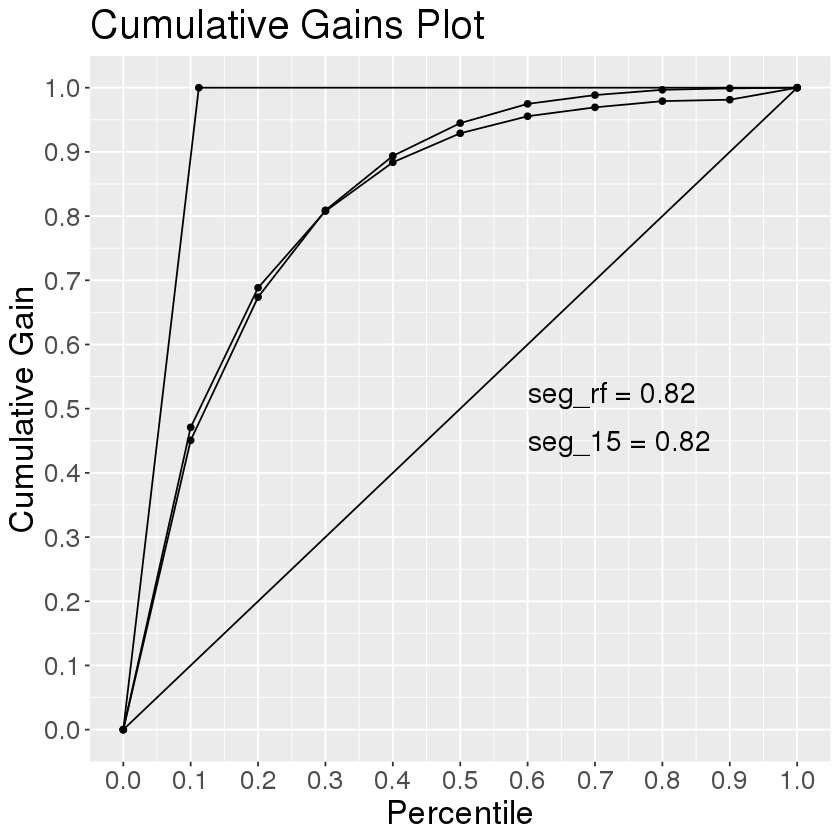

In [180]:
lift_df_seg_glm_expiry_exptest <- readRDS('../../data/lift_df_seg_glm_expiry_exptest')

source('functions_eval.R')

plot_multigains <- plot_multigains(
    lift_df_list=list(
        seg_rf = lift_df,
        seg_15 = lift_df_seg_glm_expiry_exptest),
    auc_list = list(
        seg_rf= calc_auc(lift_df),
        seg_15= calc_auc(lift_df_seg_glm_expiry_exptest)))
# png(file = "../../data/output/plot_multigains_03_summ5.png",
#     width = 500, height = 375)
plot(plot_multigains)
# dev.off()

In [181]:
calc_auc(lift_df)

[1] 0.8231176

In [182]:
calc_auc(lift_df_seg_glm_expiry_exptest)

[1] 0.8165071

In [183]:
lift_df

P,actu_renwd2,gain,lift
<dbl>,<int>,<dbl>,<dbl>
0.1,12271,0.4507089,4.507089
0.2,18344,0.6737677,3.368839
0.3,22027,0.8090428,2.696809
0.4,24334,0.8937780,2.234445
0.5,25724,0.9448321,1.889664
0.6,26540,0.9748035,1.624672
0.7,26914,0.9885404,1.412201
0.8,27137,0.9967311,1.245914
0.9,27198,0.9989716,1.109968


In [184]:
lift_df_seg_glm_expiry_exptest

P,actu_renwd2,gain,lift
<dbl>,<int>,<dbl>,<dbl>
0.1,12787,0.4708893,4.708893
0.2,18692,0.6883447,3.441723
0.3,21933,0.8076966,2.692322
0.4,24000,0.8838151,2.209538
0.5,25227,0.9290002,1.858000
0.6,25947,0.9555146,1.592524
0.7,26325,0.9694347,1.384907
0.8,26587,0.9790830,1.223854
0.9,26647,0.9812926,1.090325


# top 200

In [185]:
filename = 'seg_glm_expiry_exptest'
system(paste(sprintf("gsutil cp gs://data_input/%s /home/jupyter/local/Domains_202003/data/", filename)))
seg_glm_expiry_exptest <- readRDS(file.path("/home/jupyter/local/Domains_202003/data/", filename))

In [186]:
head(seg_glm_expiry_exptest)

renewal_type,renewed_count,expiry_date,domain_id,domain,creation_date,status,tld,registrar,reseller,⋯,sld_length,sld_type2,day_domains,log_reg_arpt,gibb_score,pattern,cluster,pattern_score,pattern_domain_count,first_renewal_prediction
<chr>,<int>,<date>,<int>,<chr>,<date>,<chr>,<fct>,<chr>,<chr>,⋯,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>
FirstTime,1,2020-01-22,91639803,segeln.fun,2019-01-22,Active,fun,1&1 internet,1&1 internet,⋯,6,6l,1,2.708050,2.23,segeln,1,1,1,0.8459141
FirstTime,1,2020-03-07,95819759,harzhotel.fun,2019-03-07,Active,fun,1&1 internet,1&1 internet,⋯,9,9l,1,2.708050,3.45,harzhotel,1,1,1,0.4607455
FirstTime,1,2020-01-15,91044973,movistar.fun,2019-01-15,Active,fun,10dencehispahard,10dencehispahard,⋯,8,8l,1,2.708050,8.62,movistar,1,1,1,NA
FirstTime,1,2020-02-01,92472913,kuinik.fun,2019-02-01,Active,fun,10dencehispahard,10dencehispahard,⋯,6,6l,1,2.708050,3.13,kuinik,1,1,1,NA
FirstTime,1,2020-01-21,91532433,bulgari.fun,2019-01-21,Active,fun,1api,1api,⋯,7,7l,1,1.609438,4.51,bulgari,1,1,1,0.9999971
FirstTime,1,2020-04-24,101717674,gotsome.fun,2019-04-24,Active,fun,1api,1api,⋯,7,7l,1,1.609438,6.09,gotsome,1,1,1,0.9999992


In [187]:
top_tld_reg <- seg_glm_expiry_exptest %>% group_by(tld_registrar_index) %>% tally() %>% arrange(desc(n)) %>% head(200) #%>% select(n)
sum(top_tld_reg$n)

sum(top_tld_reg$n)/nrow(seg_glm_expiry_exptest)

tld_registrars = top_tld_reg$tld_registrar_index
tld_registrars

[1] 273794

[1] 0.9224958

[1] "sitegmo"                       "funalibaba"                   
  [3] "sitenamecheap"                 "pwnamecheap"                  
  [5] "onlinego daddy"                "sitegandi sas"                
  [7] "sitereg.ru"                    "onlinenamecheap"              
  [9] "siteonlinenic"                 "hostnamecheap"                
 [11] "sitezhengzhou century connect" "funchengdu west"              
 [13] "spacego daddy"                 "websitenamecheap"             
 [15] "funnamecheap"                  "sitealibaba"                  
 [17] "onlinehostinger"               "spacenamecheap"               
 [19] "websiteuniregistrar"           "onlinealibaba"                
 [21] "onlinefbs"                     "sitego daddy"                 
 [23] "sitechengdu west"              "storealibaba"                 
 [25] "onlinechengdu west"            "storego daddy"                
 [27] "online1&1 internet"            "onlinedynadot"                
 [29] "pwgo daddy"                    "techhostinger"                
 [31] "spacereg.ru"                   "sitehostinger"                
 [33] "sitenetwork solutions"         "websitereg.ru"                
 [35] "funreg.ru"                     "onlinebigrock"                
 [37] "websitego daddy"               "pwgandi sas"                  
 [39] "storehostinger"                "techchengdu west"             
 [41] "sitefbs"                       "siteurl solutions"            
 [43] "onlinereg.ru"                  "storeshopify"                 
 [45] "onlineuniregistrar"            "onlineversio"                 
 [47] "techgo daddy"                  "funzhengzhou century connect" 
 [49] "spaceurl solutions"            "pwpdr ltd"                    
 [51] "sitedynadot"                   "pwdomains4bitcoins"           
 [53] "hostreg.ru"                    "onlineregister.it"            
 [55] "onlinepdr ltd"                 "techalibaba"                  
 [57] "in.netpdr ltd"                 "siteuniregistrar"             
 [59] "storenamecheap"                "onlineovh"                    
 [61] "technamecheap"                 "pwwest263 international"      
 [63] "onlinewix"                     "sitetenten"                   
 [65] "sitehostgator"                 "pwpdr china"                  
 [67] "fungo daddy"                   "onlinenamesilo"               
 [69] "hostgo daddy"                  "pressnamecheap"               
 [71] "onlineuol"                     "onlinesoluciones corporativas"
 [73] "sitenics telekom"              "storechengdu west"            
 [75] "onlineshanghai meicheng"       "spacehosting ukraine"         
 [77] "sitebeget"                     "spacegandi sas"               
 [79] "sitepdr china"                 "onlinegmo"                    
 [81] "websitegandi sas"              "pwwhois"                      
 [83] "storereg.ru"                   "sitehosting ukraine"          
 [85] "fungmo"                        "sitevalue domain"             
 [87] "spacegmo"                      "websitehostinger"             
 [89] "fundynadot"                    "onlinecronon ag"              
 [91] "fununiregistrar"               "onlinebluehost"               
 [93] "sitepdr ltd"                   "sitedotserve inc"             
 [95] "storewix"                      "onlinehome.pl"                
 [97] "websiteurl solutions"          "spacedynadot"                 
 [99] "onlineunited domains"          "onlineniaga hoster"           
[101] "sitemuumuu"                    "onlinetucows"                 
[103] "onlineurl solutions"           "onlinehostgator"              
[105] "techdotserve inc"              "spacehostinger"               
[107] "techovh"                       "onlinenetwork solutions"      
[109] "onlinewest263 international"   "pwdynadot"                    
[111] "pwreg.ru"                      "onlinetld registrar solns"    
[113] "onlinedomeny.pl"               "siteniaga hoster"             
[115] "siteo

In [188]:
seg_glm_expiry_exptest_sub <- seg_glm_expiry_exptest %>% filter(tld_registrar_index %in% tld_registrars)

In [189]:
tld_registrars
num_trees = 1000
train = expiry_train_df_sub
test = expiry_test_df_sub


train$tld_registrar_index <- tolower(paste(train$tld,train$registrar,sep=""))
test$tld_registrar_index <- tolower(paste(test$tld,test$registrar,sep=""))

train <- train %>% filter(!(tld_registrar_index %in% tld_registrars))
test <- test %>% filter(!(tld_registrar_index %in% tld_registrars))

dim(train)/dim(expiry_train_df_sub)
head(train)

[1] "sitegmo"                       "funalibaba"                   
  [3] "sitenamecheap"                 "pwnamecheap"                  
  [5] "onlinego daddy"                "sitegandi sas"                
  [7] "sitereg.ru"                    "onlinenamecheap"              
  [9] "siteonlinenic"                 "hostnamecheap"                
 [11] "sitezhengzhou century connect" "funchengdu west"              
 [13] "spacego daddy"                 "websitenamecheap"             
 [15] "funnamecheap"                  "sitealibaba"                  
 [17] "onlinehostinger"               "spacenamecheap"               
 [19] "websiteuniregistrar"           "onlinealibaba"                
 [21] "onlinefbs"                     "sitego daddy"                 
 [23] "sitechengdu west"              "storealibaba"                 
 [25] "onlinechengdu west"            "storego daddy"                
 [27] "online1&1 internet"            "onlinedynadot"                
 [29] "pwgo daddy"                    "techhostinger"                
 [31] "spacereg.ru"                   "sitehostinger"                
 [33] "sitenetwork solutions"         "websitereg.ru"                
 [35] "funreg.ru"                     "onlinebigrock"                
 [37] "websitego daddy"               "pwgandi sas"                  
 [39] "storehostinger"                "techchengdu west"             
 [41] "sitefbs"                       "siteurl solutions"            
 [43] "onlinereg.ru"                  "storeshopify"                 
 [45] "onlineuniregistrar"            "onlineversio"                 
 [47] "techgo daddy"                  "funzhengzhou century connect" 
 [49] "spaceurl solutions"            "pwpdr ltd"                    
 [51] "sitedynadot"                   "pwdomains4bitcoins"           
 [53] "hostreg.ru"                    "onlineregister.it"            
 [55] "onlinepdr ltd"                 "techalibaba"                  
 [57] "in.netpdr ltd"                 "siteuniregistrar"             
 [59] "storenamecheap"                "onlineovh"                    
 [61] "technamecheap"                 "pwwest263 international"      
 [63] "onlinewix"                     "sitetenten"                   
 [65] "sitehostgator"                 "pwpdr china"                  
 [67] "fungo daddy"                   "onlinenamesilo"               
 [69] "hostgo daddy"                  "pressnamecheap"               
 [71] "onlineuol"                     "onlinesoluciones corporativas"
 [73] "sitenics telekom"              "storechengdu west"            
 [75] "onlineshanghai meicheng"       "spacehosting ukraine"         
 [77] "sitebeget"                     "spacegandi sas"               
 [79] "sitepdr china"                 "onlinegmo"                    
 [81] "websitegandi sas"              "pwwhois"                      
 [83] "storereg.ru"                   "sitehosting ukraine"          
 [85] "fungmo"                        "sitevalue domain"             
 [87] "spacegmo"                      "websitehostinger"             
 [89] "fundynadot"                    "onlinecronon ag"              
 [91] "fununiregistrar"               "onlinebluehost"               
 [93] "sitepdr ltd"                   "sitedotserve inc"             
 [95] "storewix"                      "onlinehome.pl"                
 [97] "websiteurl solutions"          "spacedynadot"                 
 [99] "onlineunited domains"          "onlineniaga hoster"           
[101] "sitemuumuu"                    "onlinetucows"                 
[103] "onlineurl solutions"           "onlinehostgator"              
[105] "techdotserve inc"              "spacehostinger"               
[107] "techovh"                       "onlinenetwork solutions"      
[109] "onlinewest263 international"   "pwdynadot"                    
[111] "pwreg.ru"                      "onlinetld registrar solns"    
[113] "onlinedomeny.pl"               "siteniaga hoster"             
[115] "siteo

[1] 0.09101199 1.08333333

renewal_status,tld,registrar,reseller_country,region,reg_period,sld_type,sld_length,day_domains,gibb_score,pattern_domain_count,reg_arpt,tld_registrar_index
<fct>,<fct>,<chr>,<chr>,<chr>,<int>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<chr>
Renewed,fun,1&1 internet,Germany,Non China,1,l,7,1,6.77,1,15,fun1&1 internet
Renewed,fun,1&1 internet,Germany,Non China,1,ln,7,1,8.65,1,15,fun1&1 internet
Renewed,fun,1&1 internet,Germany,Non China,1,l,6,1,13.09,1,15,fun1&1 internet
Not Renewd,fun,1&1 internet,Germany,Non China,1,l,12,1,2.44,1,15,fun1&1 internet
Renewed,fun,1&1 internet,Germany,Non China,1,l,7,1,2.34,1,15,fun1&1 internet
Renewed,fun,1&1 internet,Germany,Non China,1,l,8,1,3.64,1,15,fun1&1 internet


In [190]:
cat("\nTraining & Testing remaining aggregate forest.\n")

ranger_03_reg <- ranger(
formula         = renewal_status ~ ., 
data            = train, 
importance      = 'impurity', 
num.trees       = num_trees,
    probability     = TRUE,
#     mtry            = 3,
#     min.node.size   = 10,
#     replace         = FALSE,
#     sample.fraction = .8,
seed            = 123
)

ranger_predict_03_reg <- predict(ranger_03_reg, 
                                 data = test,
                                 type="response")$predictions

ranger_predict_03_reg <- as.data.frame(ranger_predict_03_reg)$Renewed


Training & Testing remaining aggregate forest.


In [191]:
test$first_renewal_prediction <- ranger_predict_03_reg
head(test)

renewal_status,tld,registrar,reseller_country,region,reg_period,sld_type,sld_length,day_domains,gibb_score,pattern_domain_count,reg_arpt,tld_registrar_index,first_renewal_prediction
<fct>,<fct>,<chr>,<chr>,<chr>,<int>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<chr>,<dbl>
Renewed,fun,1&1 internet,Germany,Non China,1,l,6,1,2.23,1,15,fun1&1 internet,0.6242263
Renewed,fun,1&1 internet,Germany,Non China,1,l,9,1,3.45,1,15,fun1&1 internet,0.6606445
Not Renewd,fun,10dencehispahard,Spain,Non China,1,l,8,1,8.62,1,15,fun10dencehispahard,0.6266318
Not Renewd,fun,10dencehispahard,Spain,Non China,1,l,6,1,3.13,1,15,fun10dencehispahard,0.5364412
Renewed,fun,1api,Germany,Non China,1,l,7,1,4.51,1,5,fun1api,0.7758267
Not Renewd,fun,1api,Germany,Non China,1,l,7,1,6.09,1,5,fun1api,0.7659249


In [192]:
cols = names(test)
cols

[1] "renewal_status"           "tld"                     
 [3] "registrar"                "reseller_country"        
 [5] "region"                   "reg_period"              
 [7] "sld_type"                 "sld_length"              
 [9] "day_domains"              "gibb_score"              
[11] "pattern_domain_count"     "reg_arpt"                
[13] "tld_registrar_index"      "first_renewal_prediction"

In [193]:
dim(seg_glm_expiry_exptest_sub %>% select(all_of(cols)))

[1] 273794     14

In [194]:
dim(test)

[1] 26863    14

In [195]:
#992 rows missing - INVESTIGATE
agg_results = rbind(seg_glm_expiry_exptest_sub %>% select(all_of(cols)),test)
dim(agg_results)
dim(seg_glm_expiry_exptest)
dim(seg_glm_expiry_exptest)-dim(agg_results)
head(agg_results)

[1] 300657     14

[1] 296797     40

[1] -3860    26

renewal_status,tld,registrar,reseller_country,region,reg_period,sld_type,sld_length,day_domains,gibb_score,pattern_domain_count,reg_arpt,tld_registrar_index,first_renewal_prediction
<fct>,<fct>,<chr>,<chr>,<chr>,<int>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<chr>,<dbl>
Not Renewd,fun,alibaba,China,China,2,l,6,1,3.81,1,4.75,funalibaba,0.3892428
Not Renewd,fun,alibaba,China,China,2,l,7,1,6.76,1,4.75,funalibaba,0.3677247
Renewed,fun,alibaba,China,China,2,l,7,1,0.97,1,4.75,funalibaba,0.3334929
Renewed,fun,alibaba,China,China,2,l,3,1,5.71,1,4.75,funalibaba,0.5258015
Not Renewd,fun,alibaba,China,China,2,n,5,1,100.00,1,4.75,funalibaba,0.4359649
Not Renewd,fun,alibaba,China,China,2,l,4,1,4.61,1,4.75,funalibaba,0.4766606


In [196]:
df = data.frame("actual" = agg_results$renewal_status,
          "predicted" = agg_results$first_renewal_prediction)

lift_df <- chart_lift(pred_df = df,
                        dep_var = "actual",
                        pred_var = "predicted")

gains_plot <- plot_gains (lift_df) 

auc_val <- calc_auc(lift_df)


# saveRDS(lift_df_seg_glm_expiry_exptest, file.path('../../data/output/',"lift_df_seg_glm_expiry_exptest"))

In [197]:
auc_val

[1] 0.8237904

In [198]:
lift_df

P,actu_renwd2,gain,lift
<dbl>,<int>,<dbl>,<dbl>
0.1,12549,0.4490767,4.490767
0.2,18962,0.6785714,3.392857
0.3,22703,0.8124463,2.708154
0.4,25015,0.8951832,2.237958
0.5,26412,0.9451761,1.890352
0.6,27225,0.9742700,1.623783
0.7,27612,0.9881191,1.411599
0.8,27842,0.9963498,1.245437
0.9,27908,0.9987117,1.109680


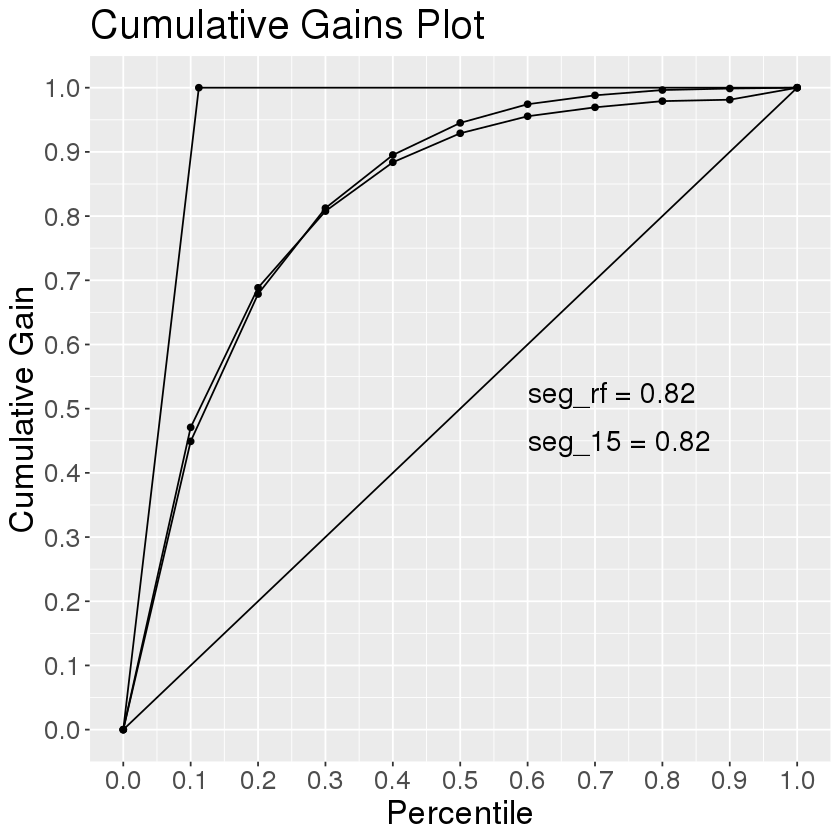

In [199]:
lift_df_seg_glm_expiry_exptest <- readRDS('../../data/lift_df_seg_glm_expiry_exptest')

source('functions_eval.R')

plot_multigains <- plot_multigains(
    lift_df_list=list(
        seg_rf = lift_df,
        seg_15 = lift_df_seg_glm_expiry_exptest),
    auc_list = list(
        seg_rf= calc_auc(lift_df),
        seg_15= calc_auc(lift_df_seg_glm_expiry_exptest)))
# png(file = "../../data/output/plot_multigains_03_summ5.png",
#     width = 500, height = 375)
plot(plot_multigains)
# dev.off()

In [200]:
calc_auc(lift_df)

[1] 0.8237904

In [201]:
calc_auc(lift_df_seg_glm_expiry_exptest)

[1] 0.8165071

In [202]:
lift_df

P,actu_renwd2,gain,lift
<dbl>,<int>,<dbl>,<dbl>
0.1,12549,0.4490767,4.490767
0.2,18962,0.6785714,3.392857
0.3,22703,0.8124463,2.708154
0.4,25015,0.8951832,2.237958
0.5,26412,0.9451761,1.890352
0.6,27225,0.9742700,1.623783
0.7,27612,0.9881191,1.411599
0.8,27842,0.9963498,1.245437
0.9,27908,0.9987117,1.109680


In [203]:
lift_df_seg_glm_expiry_exptest

P,actu_renwd2,gain,lift
<dbl>,<int>,<dbl>,<dbl>
0.1,12787,0.4708893,4.708893
0.2,18692,0.6883447,3.441723
0.3,21933,0.8076966,2.692322
0.4,24000,0.8838151,2.209538
0.5,25227,0.9290002,1.858000
0.6,25947,0.9555146,1.592524
0.7,26325,0.9694347,1.384907
0.8,26587,0.9790830,1.223854
0.9,26647,0.9812926,1.090325


# top 300

In [207]:
filename = 'seg_glm_expiry_exptest'
system(paste(sprintf("gsutil cp gs://data_input/%s /home/jupyter/local/Domains_202003/data/", filename)))
seg_glm_expiry_exptest <- readRDS(file.path("/home/jupyter/local/Domains_202003/data/", filename))

In [208]:
head(seg_glm_expiry_exptest)

renewal_type,renewed_count,expiry_date,domain_id,domain,creation_date,status,tld,registrar,reseller,⋯,sld_length,sld_type2,day_domains,log_reg_arpt,gibb_score,pattern,cluster,pattern_score,pattern_domain_count,first_renewal_prediction
<chr>,<int>,<date>,<int>,<chr>,<date>,<chr>,<fct>,<chr>,<chr>,⋯,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>
FirstTime,1,2020-01-22,91639803,segeln.fun,2019-01-22,Active,fun,1&1 internet,1&1 internet,⋯,6,6l,1,2.708050,2.23,segeln,1,1,1,0.8459141
FirstTime,1,2020-03-07,95819759,harzhotel.fun,2019-03-07,Active,fun,1&1 internet,1&1 internet,⋯,9,9l,1,2.708050,3.45,harzhotel,1,1,1,0.4607455
FirstTime,1,2020-01-15,91044973,movistar.fun,2019-01-15,Active,fun,10dencehispahard,10dencehispahard,⋯,8,8l,1,2.708050,8.62,movistar,1,1,1,NA
FirstTime,1,2020-02-01,92472913,kuinik.fun,2019-02-01,Active,fun,10dencehispahard,10dencehispahard,⋯,6,6l,1,2.708050,3.13,kuinik,1,1,1,NA
FirstTime,1,2020-01-21,91532433,bulgari.fun,2019-01-21,Active,fun,1api,1api,⋯,7,7l,1,1.609438,4.51,bulgari,1,1,1,0.9999971
FirstTime,1,2020-04-24,101717674,gotsome.fun,2019-04-24,Active,fun,1api,1api,⋯,7,7l,1,1.609438,6.09,gotsome,1,1,1,0.9999992


In [210]:
top_tld_reg <- seg_glm_expiry_exptest %>% group_by(tld_registrar_index) %>% tally() %>% arrange(desc(n)) %>% head(300) #%>% select(n)
sum(top_tld_reg$n)

sum(top_tld_reg$n)/nrow(seg_glm_expiry_exptest)

tld_registrars = top_tld_reg$tld_registrar_index
tld_registrars

[1] 283641

[1] 0.9556734

[1] "sitegmo"                       "funalibaba"                   
  [3] "sitenamecheap"                 "pwnamecheap"                  
  [5] "onlinego daddy"                "sitegandi sas"                
  [7] "sitereg.ru"                    "onlinenamecheap"              
  [9] "siteonlinenic"                 "hostnamecheap"                
 [11] "sitezhengzhou century connect" "funchengdu west"              
 [13] "spacego daddy"                 "websitenamecheap"             
 [15] "funnamecheap"                  "sitealibaba"                  
 [17] "onlinehostinger"               "spacenamecheap"               
 [19] "websiteuniregistrar"           "onlinealibaba"                
 [21] "onlinefbs"                     "sitego daddy"                 
 [23] "sitechengdu west"              "storealibaba"                 
 [25] "onlinechengdu west"            "storego daddy"                
 [27] "online1&1 internet"            "onlinedynadot"                
 [29] "pwgo daddy"                    "techhostinger"                
 [31] "spacereg.ru"                   "sitehostinger"                
 [33] "sitenetwork solutions"         "websitereg.ru"                
 [35] "funreg.ru"                     "onlinebigrock"                
 [37] "websitego daddy"               "pwgandi sas"                  
 [39] "storehostinger"                "techchengdu west"             
 [41] "sitefbs"                       "siteurl solutions"            
 [43] "onlinereg.ru"                  "storeshopify"                 
 [45] "onlineuniregistrar"            "onlineversio"                 
 [47] "techgo daddy"                  "funzhengzhou century connect" 
 [49] "spaceurl solutions"            "pwpdr ltd"                    
 [51] "sitedynadot"                   "pwdomains4bitcoins"           
 [53] "hostreg.ru"                    "onlineregister.it"            
 [55] "onlinepdr ltd"                 "techalibaba"                  
 [57] "in.netpdr ltd"                 "siteuniregistrar"             
 [59] "storenamecheap"                "onlineovh"                    
 [61] "technamecheap"                 "pwwest263 international"      
 [63] "onlinewix"                     "sitetenten"                   
 [65] "sitehostgator"                 "pwpdr china"                  
 [67] "fungo daddy"                   "onlinenamesilo"               
 [69] "hostgo daddy"                  "pressnamecheap"               
 [71] "onlineuol"                     "onlinesoluciones corporativas"
 [73] "sitenics telekom"              "storechengdu west"            
 [75] "onlineshanghai meicheng"       "spacehosting ukraine"         
 [77] "sitebeget"                     "spacegandi sas"               
 [79] "sitepdr china"                 "onlinegmo"                    
 [81] "websitegandi sas"              "pwwhois"                      
 [83] "storereg.ru"                   "sitehosting ukraine"          
 [85] "fungmo"                        "sitevalue domain"             
 [87] "spacegmo"                      "websitehostinger"             
 [89] "fundynadot"                    "onlinecronon ag"              
 [91] "fununiregistrar"               "onlinebluehost"               
 [93] "sitepdr ltd"                   "sitedotserve inc"             
 [95] "storewix"                      "onlinehome.pl"                
 [97] "websiteurl solutions"          "spacedynadot"                 
 [99] "onlineunited domains"          "onlineniaga hoster"           
[101] "sitemuumuu"                    "onlinetucows"                 
[103] "onlineurl solutions"           "onlinehostgator"              
[105] "techdotserve inc"              "spacehostinger"               
[107] "techovh"                       "onlinenetwork solutions"      
[109] "onlinewest263 international"   "pwdynadot"                    
[111] "pwreg.ru"                      "onlinetld registrar solns"    
[113] "onlinedomeny.pl"               "siteniaga hoster"             
[115] "siteo

In [211]:
seg_glm_expiry_exptest_sub <- seg_glm_expiry_exptest %>% filter(tld_registrar_index %in% tld_registrars)

In [212]:
tld_registrars
num_trees = 1000
train = expiry_train_df_sub
test = expiry_test_df_sub


train$tld_registrar_index <- tolower(paste(train$tld,train$registrar,sep=""))
test$tld_registrar_index <- tolower(paste(test$tld,test$registrar,sep=""))

train <- train %>% filter(!(tld_registrar_index %in% tld_registrars))
test <- test %>% filter(!(tld_registrar_index %in% tld_registrars))

dim(train)/dim(expiry_train_df_sub)
head(train)

[1] "sitegmo"                       "funalibaba"                   
  [3] "sitenamecheap"                 "pwnamecheap"                  
  [5] "onlinego daddy"                "sitegandi sas"                
  [7] "sitereg.ru"                    "onlinenamecheap"              
  [9] "siteonlinenic"                 "hostnamecheap"                
 [11] "sitezhengzhou century connect" "funchengdu west"              
 [13] "spacego daddy"                 "websitenamecheap"             
 [15] "funnamecheap"                  "sitealibaba"                  
 [17] "onlinehostinger"               "spacenamecheap"               
 [19] "websiteuniregistrar"           "onlinealibaba"                
 [21] "onlinefbs"                     "sitego daddy"                 
 [23] "sitechengdu west"              "storealibaba"                 
 [25] "onlinechengdu west"            "storego daddy"                
 [27] "online1&1 internet"            "onlinedynadot"                
 [29] "pwgo daddy"                    "techhostinger"                
 [31] "spacereg.ru"                   "sitehostinger"                
 [33] "sitenetwork solutions"         "websitereg.ru"                
 [35] "funreg.ru"                     "onlinebigrock"                
 [37] "websitego daddy"               "pwgandi sas"                  
 [39] "storehostinger"                "techchengdu west"             
 [41] "sitefbs"                       "siteurl solutions"            
 [43] "onlinereg.ru"                  "storeshopify"                 
 [45] "onlineuniregistrar"            "onlineversio"                 
 [47] "techgo daddy"                  "funzhengzhou century connect" 
 [49] "spaceurl solutions"            "pwpdr ltd"                    
 [51] "sitedynadot"                   "pwdomains4bitcoins"           
 [53] "hostreg.ru"                    "onlineregister.it"            
 [55] "onlinepdr ltd"                 "techalibaba"                  
 [57] "in.netpdr ltd"                 "siteuniregistrar"             
 [59] "storenamecheap"                "onlineovh"                    
 [61] "technamecheap"                 "pwwest263 international"      
 [63] "onlinewix"                     "sitetenten"                   
 [65] "sitehostgator"                 "pwpdr china"                  
 [67] "fungo daddy"                   "onlinenamesilo"               
 [69] "hostgo daddy"                  "pressnamecheap"               
 [71] "onlineuol"                     "onlinesoluciones corporativas"
 [73] "sitenics telekom"              "storechengdu west"            
 [75] "onlineshanghai meicheng"       "spacehosting ukraine"         
 [77] "sitebeget"                     "spacegandi sas"               
 [79] "sitepdr china"                 "onlinegmo"                    
 [81] "websitegandi sas"              "pwwhois"                      
 [83] "storereg.ru"                   "sitehosting ukraine"          
 [85] "fungmo"                        "sitevalue domain"             
 [87] "spacegmo"                      "websitehostinger"             
 [89] "fundynadot"                    "onlinecronon ag"              
 [91] "fununiregistrar"               "onlinebluehost"               
 [93] "sitepdr ltd"                   "sitedotserve inc"             
 [95] "storewix"                      "onlinehome.pl"                
 [97] "websiteurl solutions"          "spacedynadot"                 
 [99] "onlineunited domains"          "onlineniaga hoster"           
[101] "sitemuumuu"                    "onlinetucows"                 
[103] "onlineurl solutions"           "onlinehostgator"              
[105] "techdotserve inc"              "spacehostinger"               
[107] "techovh"                       "onlinenetwork solutions"      
[109] "onlinewest263 international"   "pwdynadot"                    
[111] "pwreg.ru"                      "onlinetld registrar solns"    
[113] "onlinedomeny.pl"               "siteniaga hoster"             
[115] "siteo

[1] 0.05681044 1.08333333

renewal_status,tld,registrar,reseller_country,region,reg_period,sld_type,sld_length,day_domains,gibb_score,pattern_domain_count,reg_arpt,tld_registrar_index
<fct>,<fct>,<chr>,<chr>,<chr>,<int>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<chr>
Renewed,fun,1&1 internet,Germany,Non China,1,l,7,1,6.77,1,15,fun1&1 internet
Renewed,fun,1&1 internet,Germany,Non China,1,ln,7,1,8.65,1,15,fun1&1 internet
Renewed,fun,1&1 internet,Germany,Non China,1,l,6,1,13.09,1,15,fun1&1 internet
Not Renewd,fun,1&1 internet,Germany,Non China,1,l,12,1,2.44,1,15,fun1&1 internet
Renewed,fun,1&1 internet,Germany,Non China,1,l,7,1,2.34,1,15,fun1&1 internet
Renewed,fun,1&1 internet,Germany,Non China,1,l,8,1,3.64,1,15,fun1&1 internet


In [213]:
cat("\nTraining & Testing remaining aggregate forest.\n")

ranger_03_reg <- ranger(
formula         = renewal_status ~ ., 
data            = train, 
importance      = 'impurity', 
num.trees       = num_trees,
    probability     = TRUE,
#     mtry            = 3,
#     min.node.size   = 10,
#     replace         = FALSE,
#     sample.fraction = .8,
seed            = 123
)

ranger_predict_03_reg <- predict(ranger_03_reg, 
                                 data = test,
                                 type="response")$predictions

ranger_predict_03_reg <- as.data.frame(ranger_predict_03_reg)$Renewed


Training & Testing remaining aggregate forest.


In [214]:
test$first_renewal_prediction <- ranger_predict_03_reg
head(test)

renewal_status,tld,registrar,reseller_country,region,reg_period,sld_type,sld_length,day_domains,gibb_score,pattern_domain_count,reg_arpt,tld_registrar_index,first_renewal_prediction
<fct>,<fct>,<chr>,<chr>,<chr>,<int>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<chr>,<dbl>
Renewed,fun,1&1 internet,Germany,Non China,1,l,6,1,2.23,1,15,fun1&1 internet,0.5961632
Renewed,fun,1&1 internet,Germany,Non China,1,l,9,1,3.45,1,15,fun1&1 internet,0.6493155
Not Renewd,fun,10dencehispahard,Spain,Non China,1,l,8,1,8.62,1,15,fun10dencehispahard,0.6171973
Not Renewd,fun,10dencehispahard,Spain,Non China,1,l,6,1,3.13,1,15,fun10dencehispahard,0.5266072
Renewed,fun,1api,Germany,Non China,1,l,7,1,4.51,1,5,fun1api,0.7745300
Not Renewd,fun,1api,Germany,Non China,1,l,7,1,6.09,1,5,fun1api,0.7618329


In [215]:
cols = names(test)
cols

[1] "renewal_status"           "tld"                     
 [3] "registrar"                "reseller_country"        
 [5] "region"                   "reg_period"              
 [7] "sld_type"                 "sld_length"              
 [9] "day_domains"              "gibb_score"              
[11] "pattern_domain_count"     "reg_arpt"                
[13] "tld_registrar_index"      "first_renewal_prediction"

In [216]:
dim(seg_glm_expiry_exptest_sub %>% select(all_of(cols)))

[1] 283641     14

In [217]:
dim(test)

[1] 16800    14

In [218]:
#992 rows missing - INVESTIGATE
agg_results = rbind(seg_glm_expiry_exptest_sub %>% select(all_of(cols)),test)
dim(agg_results)
dim(seg_glm_expiry_exptest)
dim(seg_glm_expiry_exptest)-dim(agg_results)
head(agg_results)

[1] 300441     14

[1] 296797     40

[1] -3644    26

renewal_status,tld,registrar,reseller_country,region,reg_period,sld_type,sld_length,day_domains,gibb_score,pattern_domain_count,reg_arpt,tld_registrar_index,first_renewal_prediction
<fct>,<fct>,<chr>,<chr>,<chr>,<int>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<chr>,<dbl>
Not Renewd,fun,alibaba,China,China,2,l,6,1,3.81,1,4.75,funalibaba,0.3892428
Not Renewd,fun,alibaba,China,China,2,l,7,1,6.76,1,4.75,funalibaba,0.3677247
Renewed,fun,alibaba,China,China,2,l,7,1,0.97,1,4.75,funalibaba,0.3334929
Renewed,fun,alibaba,China,China,2,l,3,1,5.71,1,4.75,funalibaba,0.5258015
Not Renewd,fun,alibaba,China,China,2,n,5,1,100.00,1,4.75,funalibaba,0.4359649
Not Renewd,fun,alibaba,China,China,2,l,4,1,4.61,1,4.75,funalibaba,0.4766606


In [219]:
df = data.frame("actual" = agg_results$renewal_status,
          "predicted" = agg_results$first_renewal_prediction)

lift_df <- chart_lift(pred_df = df,
                        dep_var = "actual",
                        pred_var = "predicted")

gains_plot <- plot_gains (lift_df) 

auc_val <- calc_auc(lift_df)


# saveRDS(lift_df_seg_glm_expiry_exptest, file.path('../../data/output/',"lift_df_seg_glm_expiry_exptest"))

In [220]:
auc_val

[1] 0.8261055

In [221]:
lift_df

P,actu_renwd2,gain,lift
<dbl>,<int>,<dbl>,<dbl>
0.1,12765,0.4600497,4.600497
0.2,19112,0.6887952,3.443976
0.3,22641,0.8159801,2.719934
0.4,24882,0.8967456,2.241864
0.5,26224,0.9451112,1.890222
0.6,27006,0.9732944,1.622157
0.7,27391,0.9871698,1.410243
0.8,27629,0.9957473,1.244684
0.9,27696,0.9981620,1.109069


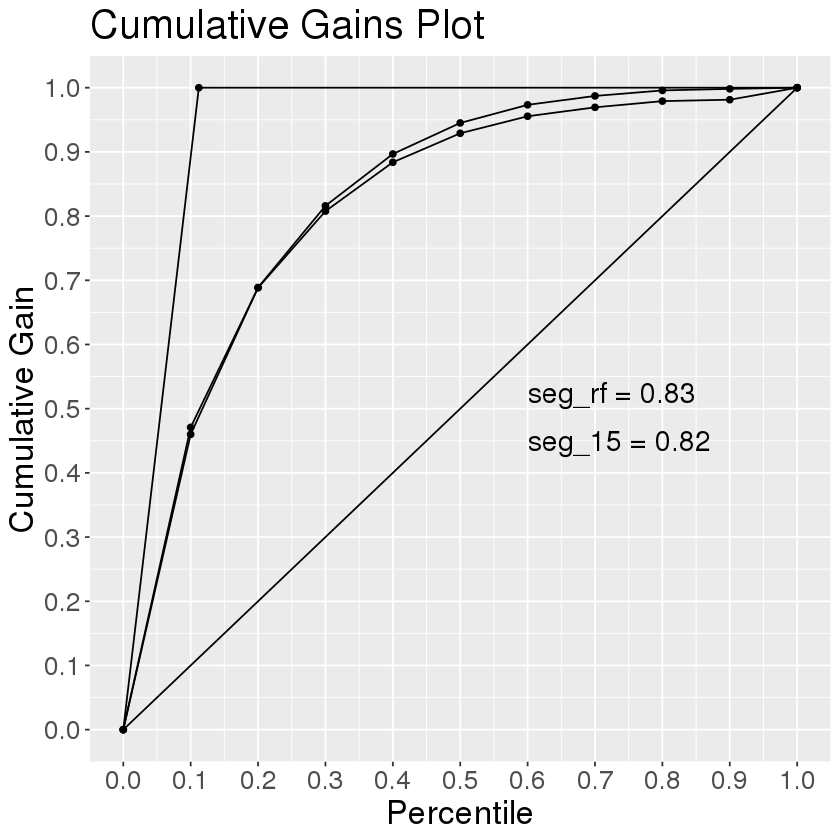

In [222]:
lift_df_seg_glm_expiry_exptest <- readRDS('../../data/lift_df_seg_glm_expiry_exptest')

source('functions_eval.R')

plot_multigains <- plot_multigains(
    lift_df_list=list(
        seg_rf = lift_df,
        seg_15 = lift_df_seg_glm_expiry_exptest),
    auc_list = list(
        seg_rf= calc_auc(lift_df),
        seg_15= calc_auc(lift_df_seg_glm_expiry_exptest)))
# png(file = "../../data/output/plot_multigains_03_summ5.png",
#     width = 500, height = 375)
plot(plot_multigains)
# dev.off()

In [223]:
calc_auc(lift_df)

[1] 0.8261055

In [224]:
calc_auc(lift_df_seg_glm_expiry_exptest)

[1] 0.8165071

In [225]:
lift_df

P,actu_renwd2,gain,lift
<dbl>,<int>,<dbl>,<dbl>
0.1,12765,0.4600497,4.600497
0.2,19112,0.6887952,3.443976
0.3,22641,0.8159801,2.719934
0.4,24882,0.8967456,2.241864
0.5,26224,0.9451112,1.890222
0.6,27006,0.9732944,1.622157
0.7,27391,0.9871698,1.410243
0.8,27629,0.9957473,1.244684
0.9,27696,0.9981620,1.109069


In [226]:
lift_df_seg_glm_expiry_exptest

P,actu_renwd2,gain,lift
<dbl>,<int>,<dbl>,<dbl>
0.1,12787,0.4708893,4.708893
0.2,18692,0.6883447,3.441723
0.3,21933,0.8076966,2.692322
0.4,24000,0.8838151,2.209538
0.5,25227,0.9290002,1.858000
0.6,25947,0.9555146,1.592524
0.7,26325,0.9694347,1.384907
0.8,26587,0.9790830,1.223854
0.9,26647,0.9812926,1.090325


# RF for the rest

In [3]:
reg_name = 'gmo'

# subset data

dim(expiry_train_df_sub)
dim(expiry_test_df_sub)
cat('\n')

expiry_train_df_sub_reg <- expiry_train_df_sub %>% filter(registrar==reg_name)
expiry_test_df_sub_reg <- expiry_test_df_sub %>% filter(registrar==reg_name)


dim(expiry_train_df_sub_reg)
dim(expiry_test_df_sub_reg)
cat('\n')


dim(expiry_train_df_sub_reg)/dim(expiry_train_df_sub)
dim(expiry_test_df_sub_reg)/dim(expiry_test_df_sub)

[1] 1188250      12

[1] 296797     12

[1] 126254     12

[1] 31494    12

[1] 0.1062521 1.0000000

[1] 0.1061129 1.0000000

In [4]:
# train & test RF


ranger_03_reg <- ranger(
    formula         = renewal_status ~ ., 
    data            = expiry_train_df_sub_reg, 
    importance = 'impurity', 
    num.trees       = 1000,
    probability = TRUE,
    mtry            = 3,
    min.node.size   = 10,
    replace = FALSE,
    sample.fraction = .8,
    seed            = 123
)

ranger_predict_03_reg <- predict(ranger_03_reg, 
                          data = expiry_test_df_sub_reg,
                          type="response")$predictions

ranger_predict_03_reg <- as.data.frame(ranger_predict_03_reg)$Renewed

ranger_03_pred_df_reg = data.frame("actual" = expiry_test_df_sub_reg$renewal_status,
          "predicted" = ranger_predict_03_reg)

lift_df_ranger_03_reg <- chart_lift(pred_df = ranger_03_pred_df_reg,
                        dep_var = "actual",
                        pred_var = "predicted")

gains_plot_ranger_03_reg <- plot_gains (lift_df_ranger_03_reg) 

auc_ranger_03_reg <- calc_auc(lift_df_ranger_03_reg)
toc()







# save(ranger_03_reg, file="../../data/output/ranger_03_reg")
# save(ranger_predict_03_reg, 
#      file="../../data/output/ranger_predict_03_reg")
# saveRDS(lift_df_ranger_03_reg, file.path('../../data/output/',"lift_df_ranger_03_reg"))



In [5]:
auc_ranger_03_reg

[1] 0.760696

# Seg_GLM for one registrar of choice

In [6]:
filename = 'seg_glm_expiry_exptest'
system(paste(sprintf("gsutil cp gs://data_input/%s /home/jupyter/local/Domains_202003/data/", filename)))
seg_glm_expiry_exptest <- readRDS(file.path("/home/jupyter/local/Domains_202003/data/", filename))

In [7]:
reg_name = 'gmo'

# subset data

dim(seg_glm_expiry_exptest)
cat('\n')

seg_glm_expiry_exptest_reg <-seg_glm_expiry_exptest %>% filter(registrar==reg_name)


dim(seg_glm_expiry_exptest_reg)
cat('\n')


dim(seg_glm_expiry_exptest_reg)/dim(seg_glm_expiry_exptest)



[1] 296797     40

[1] 31494    40

[1] 0.1061129 1.0000000

In [8]:
seg_glm_expiry_exptest_pred_df_reg = data.frame("actual" = seg_glm_expiry_exptest_reg$renewal_status,
          "predicted" = seg_glm_expiry_exptest_reg$first_renewal_prediction)

lift_df_seg_glm_expiry_exptest_reg <- chart_lift(pred_df = seg_glm_expiry_exptest_pred_df_reg,
                        dep_var = "actual",
                        pred_var = "predicted")

gains_plot_seg_glm_expiry_exptest_reg <- plot_gains (lift_df_seg_glm_expiry_exptest_reg) 

auc_seg_glm_expiry_exptest_reg<- calc_auc(lift_df_seg_glm_expiry_exptest_reg)


# saveRDS(lift_df_seg_glm_expiry_exptest, file.path('../../data/output/',"lift_df_seg_glm_expiry_exptest"))

In [9]:
auc_seg_glm_expiry_exptest_reg

[1] 0.8876557

In [10]:
prop.table(table(seg_glm_expiry_exptest_reg$renewal_status))


   Renewed Not Renewd 
0.04334159 0.95665841 

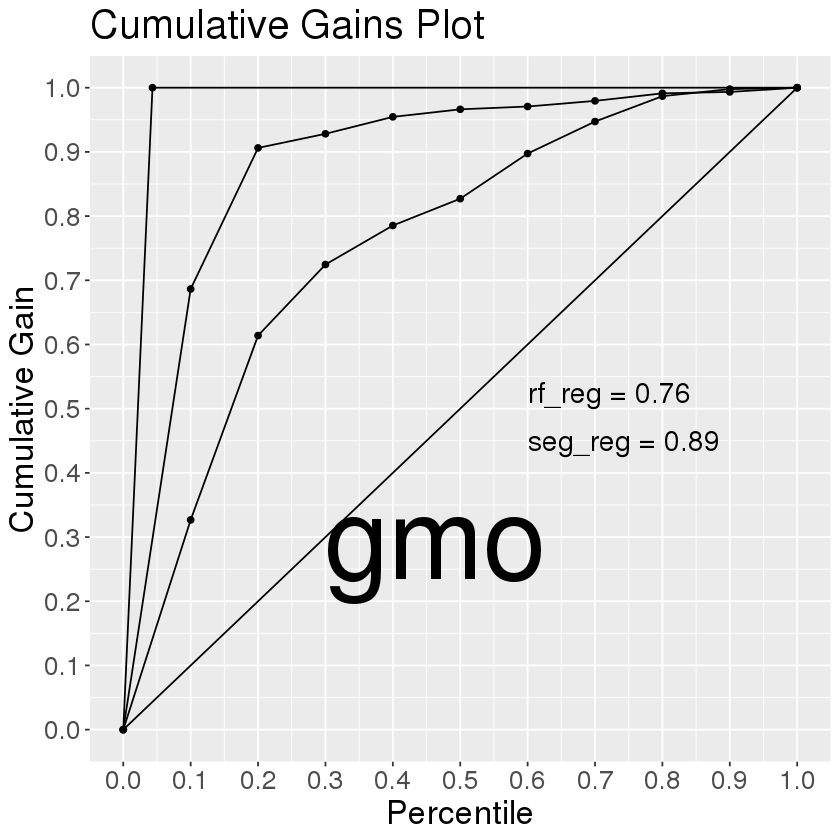

In [12]:
plot_multigains_reg <- plot_multigains(
    lift_df_list=list(
        rf_reg = lift_df_ranger_03_reg,
        seg_reg = lift_df_seg_glm_expiry_exptest_reg),
    auc_list = list(
        rf_reg= calc_auc(lift_df_ranger_03_reg),
        seg_reg= calc_auc(lift_df_seg_glm_expiry_exptest_reg)),
    prop_positive = 0.04334159)
# png(file = "../../data/output/plot_multigains_03_summ4.png",
#     width = 500, height = 375)
plot(plot_multigains_reg + 
      annotate("text", x = .3, y = .3, hjust = 0, label=reg_name, size = 24))
# dev.off()

# Train GLM from "scratch"

In [17]:
reg_name

[1] "gmo"

In [30]:
grep(reg_name, names(expiry_train_prepped_2), value=TRUE)

[1] "fungmo"     "hostgmo"    "in.netgmo"  "onlinegmo"  "pressgmo"  
 [6] "pwgmo"      "sitegmo"    "spacegmo"   "storegmo"   "techgmo"   
[11] "websitegmo"

In [34]:
train_df <- rbindlist(expiry_train_prepped_2[grep(reg_name, names(expiry_train_prepped_2), value=TRUE)],use.names=TRUE)
dim(train_df)

[1] 115069     39

In [35]:
unique(train_df$registrar)

[1] "gmo"

In [37]:
model_reg <- build_model_first_renewal_reg(train_df)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


In [38]:
summary(model_reg)


Call:
glm(formula = renewal_status ~ ., family = binomial(link = "logit"), 
    data = build_data, model = FALSE, y = FALSE)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2880  -0.2497  -0.0914  -0.0042   5.6456  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -4.158e-01  2.125e-01  -1.957 0.050346 .  
pattern_domain_count -5.289e-01  4.001e-02 -13.219  < 2e-16 ***
log_reg_arpt          2.293e-01  7.309e-02   3.138 0.001703 ** 
sld_length            2.055e-02  5.045e-03   4.073 4.65e-05 ***
sld_typehyphen-ln    -2.900e+00  2.308e-01 -12.561  < 2e-16 ***
sld_typel            -1.335e+00  5.249e-02 -25.436  < 2e-16 ***
sld_typeln           -2.433e+00  8.296e-02 -29.324  < 2e-16 ***
sld_typen            -5.742e+00  5.147e-01 -11.156  < 2e-16 ***
sld_typeidn          -6.722e-01  1.134e-01  -5.930 3.03e-09 ***
day_domains          -6.708e-04  2.315e-05 -28.970  < 2e-16 ***
gibb_score            4.828e-02  2.608e-0

In [40]:
test_df <- rbindlist(expiry_test_prepped_2[grep(reg_name, names(expiry_test_prepped_2), value=TRUE)],use.names=TRUE)
dim(test_df)

[1] 28576    39

In [45]:
head(test_df)

renewal_type,renewed_count,expiry_date,domain_id,domain,creation_date,status,tld,registrar,reseller,⋯,sld_type,sld_length,sld_type2,day_domains,log_reg_arpt,gibb_score,pattern,cluster,pattern_score,pattern_domain_count
<chr>,<int>,<date>,<int>,<chr>,<date>,<chr>,<fct>,<chr>,<chr>,⋯,<fct>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>
FirstTime,1,2020-04-25,47208612,uranai.fun,2017-04-25,Active,fun,gmo,gmo,⋯,l,6,6l,1,2.457021,7.88,uranai,1,1,1
FirstTime,1,2020-01-15,59495443,tea-time.fun,2018-01-15,Active,fun,gmo,gmo,⋯,hyphen-l,8,8hyphen-l,1,2.110213,9.25,tea-time,1,1,1
FirstTime,1,2020-02-12,60982952,movie-mania.fun,2018-02-12,Active,fun,gmo,gmo,⋯,hyphen-l,11,11hyphen-l,1,2.079442,6.38,movie-mania,1,1,1
FirstTime,1,2020-02-24,61743467,good-luck.fun,2018-02-24,Active,fun,gmo,gmo,⋯,hyphen-l,9,9hyphen-l,1,2.079442,2.65,good-luck,1,1,1
FirstTime,1,2020-03-07,62380617,mojomojo.fun,2018-03-07,Active,fun,gmo,gmo,⋯,l,8,8l,1,2.079442,3.41,mojomojo,1,1,1
FirstTime,1,2020-03-10,63096237,myao.fun,2018-03-10,Active,fun,gmo,gmo,⋯,l,4,4l,1,2.079442,0.61,myao,1,1,1


In [58]:
pred_reg <- predict_first_renewal_reg(test_df, model_reg)

In [59]:
head(pred_reg)

renewal_type,renewed_count,expiry_date,domain_id,domain,creation_date,status,tld,registrar,reseller,⋯,sld_type2,day_domains,log_reg_arpt,gibb_score,pattern,cluster,pattern_score,pattern_domain_count,probabilities,first_renewal_prediction
<chr>,<int>,<date>,<int>,<chr>,<date>,<chr>,<fct>,<chr>,<chr>,⋯,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>
FirstTime,1,2020-04-25,47208612,uranai.fun,2017-04-25,Active,fun,gmo,gmo,⋯,6l,1,2.457021,7.88,uranai,1,1,1,0.6442021,0.644
FirstTime,1,2020-01-15,59495443,tea-time.fun,2018-01-15,Active,fun,gmo,gmo,⋯,8hyphen-l,1,2.110213,9.25,tea-time,1,1,1,0.7948046,0.795
FirstTime,1,2020-02-12,60982952,movie-mania.fun,2018-02-12,Active,fun,gmo,gmo,⋯,11hyphen-l,1,2.079442,6.38,movie-mania,1,1,1,0.7807682,0.781
FirstTime,1,2020-02-24,61743467,good-luck.fun,2018-02-24,Active,fun,gmo,gmo,⋯,9hyphen-l,1,2.079442,2.65,good-luck,1,1,1,0.7405752,0.741
FirstTime,1,2020-03-07,62380617,mojomojo.fun,2018-03-07,Active,fun,gmo,gmo,⋯,8l,1,2.079442,3.41,mojomojo,1,1,1,0.4329139,0.433
FirstTime,1,2020-03-10,63096237,myao.fun,2018-03-10,Active,fun,gmo,gmo,⋯,4l,1,2.079442,0.61,myao,1,1,1,0.3805173,0.381


In [60]:

lift_temp <- chart_lift(
    pred_df = data.frame("actual" = pred_reg$renewal_status,
                         "predicted" = pred_reg$first_renewal_prediction),
                        dep_var = "actual",
                        pred_var = "predicted")

gains_temp <- plot_gains (lift_temp) 

auc_temp <- calc_auc(lift_temp)


# saveRDS(lift_df_seg_glm_expiry_exptest, file.path('../../data/output/',"lift_df_seg_glm_expiry_exptest"))

In [61]:
auc_temp

[1] 0.8928425

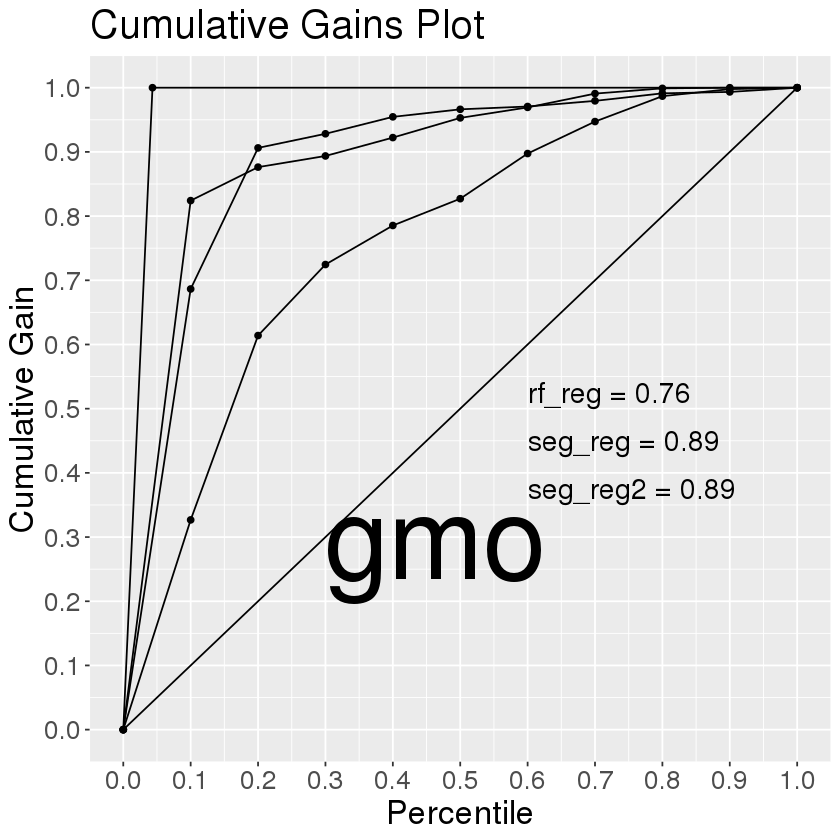

In [63]:
plot_multigains_reg <- plot_multigains(
    lift_df_list=list(
        rf_reg = lift_df_ranger_03_reg,
        seg_reg = lift_df_seg_glm_expiry_exptest_reg,
        seg_reg2 = lift_temp),
    auc_list = list(
        rf_reg= calc_auc(lift_df_ranger_03_reg),
        seg_reg= calc_auc(lift_df_seg_glm_expiry_exptest_reg),
        seg_reg2= calc_auc(lift_temp)),
    prop_positive = 0.04334159)
# png(file = "../../data/output/plot_multigains_03_summ4.png",
#     width = 500, height = 375)
plot(plot_multigains_reg + 
      annotate("text", x = .3, y = .3, hjust = 0, label=reg_name, size = 24))
# dev.off()

# Another One!

In [36]:
reg_name='namecheap'

In [37]:
# RF 

# subset data

dim(expiry_train_df_sub)
dim(expiry_test_df_sub)
cat('\n')

expiry_train_df_sub_reg <- expiry_train_df_sub %>% filter(registrar==reg_name)
expiry_test_df_sub_reg <- expiry_test_df_sub %>% filter(registrar==reg_name)


dim(expiry_train_df_sub_reg)
dim(expiry_test_df_sub_reg)
cat('\n')


dim(expiry_train_df_sub_reg)/dim(expiry_train_df_sub)
dim(expiry_test_df_sub_reg)/dim(expiry_test_df_sub)

# train & test RF
ranger_03_reg <- ranger(
    formula         = renewal_status ~ ., 
    data            = expiry_test_df_sub_reg, 
    importance = 'impurity', 
    num.trees       = 1000,
    probability = TRUE,
    mtry            = 3,
    min.node.size   = 10,
    replace = FALSE,
    sample.fraction = .8,
    seed            = 123
)

ranger_predict_03_reg <- predict(ranger_03_reg, 
                          data = expiry_test_df_sub_reg,
                          type="response")$predictions

ranger_predict_03_reg <- as.data.frame(ranger_predict_03_reg)$Renewed

ranger_03_pred_df_reg = data.frame("actual" = expiry_test_df_sub_reg$renewal_status,
          "predicted" = ranger_predict_03_reg)

lift_df_ranger_03_reg <- chart_lift(pred_df = ranger_03_pred_df_reg,
                        dep_var = "actual",
                        pred_var = "predicted")

gains_plot_ranger_03_reg <- plot_gains (lift_df_ranger_03_reg) 

auc_ranger_03_reg <- calc_auc(lift_df_ranger_03_reg)

# save(ranger_03_reg, file="../../data/output/ranger_03_reg")
# save(ranger_predict_03_reg, 
#      file="../../data/output/ranger_predict_03_reg")
# saveRDS(lift_df_ranger_03_reg, file.path('../../data/output/',"lift_df_ranger_03_reg"))



[1] 1188250      12

[1] 296797     12

[1] 221470     12

[1] 55117    12

[1] 0.1863833 1.0000000

[1] 0.1857061 1.0000000

In [38]:
# seg_glm

# subset data

dim(seg_glm_expiry_exptest)
cat('\n')

seg_glm_expiry_exptest_reg <-seg_glm_expiry_exptest %>% filter(registrar==reg_name)


dim(seg_glm_expiry_exptest_reg)
cat('\n')


dim(seg_glm_expiry_exptest_reg)/dim(seg_glm_expiry_exptest)



seg_glm_expiry_exptest_pred_df_reg = data.frame("actual" = seg_glm_expiry_exptest_reg$renewal_status,
          "predicted" = seg_glm_expiry_exptest_reg$first_renewal_prediction)

lift_df_seg_glm_expiry_exptest_reg <- chart_lift(pred_df = seg_glm_expiry_exptest_pred_df_reg,
                        dep_var = "actual",
                        pred_var = "predicted")

gains_plot_seg_glm_expiry_exptest_reg <- plot_gains (lift_df_seg_glm_expiry_exptest_reg) 

auc_seg_glm_expiry_exptest_reg<- calc_auc(lift_df_seg_glm_expiry_exptest_reg)


# saveRDS(lift_df_seg_glm_expiry_exptest, file.path('../../data/output/',"lift_df_seg_glm_expiry_exptest"))

[1] 296797     40

[1] 55117    40

[1] 0.1857061 1.0000000

In [39]:
prop.table(table(seg_glm_expiry_exptest_reg$renewal_status))


   Renewed Not Renewd 
0.06038064 0.93961936 

In [42]:
prop_positive = prop.table(table(seg_glm_expiry_exptest_reg$renewal_status))[[1]]
prop_positive

[1] 0.06038064

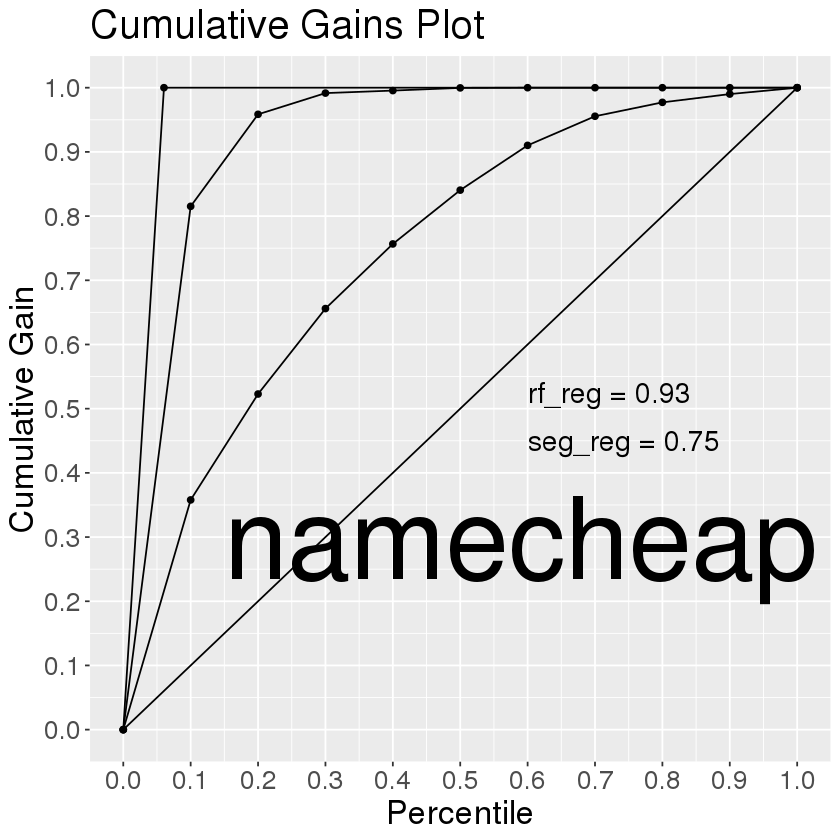

In [45]:
plot_multigains_reg <- plot_multigains(
    lift_df_list=list(
        rf_reg = lift_df_ranger_03_reg,
        seg_reg = lift_df_seg_glm_expiry_exptest_reg),
    auc_list = list(
        rf_reg= calc_auc(lift_df_ranger_03_reg),
        seg_reg= calc_auc(lift_df_seg_glm_expiry_exptest_reg)),
    prop_positive = prop_positive)
# png(file = "../../data/output/plot_multigains_03_summ4.png",
#     width = 500, height = 375)
plot(plot_multigains_reg + 
      annotate("text", x = .15, y = .3, hjust = 0, label=reg_name, size = 24))
# dev.off()

# Uno Mas!

In [46]:
reg_name='alibaba'

In [47]:
# RF 

# subset data

dim(expiry_train_df_sub)
dim(expiry_test_df_sub)
cat('\n')

expiry_train_df_sub_reg <- expiry_train_df_sub %>% filter(registrar==reg_name)
expiry_test_df_sub_reg <- expiry_test_df_sub %>% filter(registrar==reg_name)


dim(expiry_train_df_sub_reg)
dim(expiry_test_df_sub_reg)
cat('\n')


dim(expiry_train_df_sub_reg)/dim(expiry_train_df_sub)
dim(expiry_test_df_sub_reg)/dim(expiry_test_df_sub)

# train & test RF
ranger_03_reg <- ranger(
    formula         = renewal_status ~ ., 
    data            = expiry_test_df_sub_reg, 
    importance = 'impurity', 
    num.trees       = 1000,
    probability = TRUE,
    mtry            = 3,
    min.node.size   = 10,
    replace = FALSE,
    sample.fraction = .8,
    seed            = 123
)

ranger_predict_03_reg <- predict(ranger_03_reg, 
                          data = expiry_test_df_sub_reg,
                          type="response")$predictions

ranger_predict_03_reg <- as.data.frame(ranger_predict_03_reg)$Renewed

ranger_03_pred_df_reg = data.frame("actual" = expiry_test_df_sub_reg$renewal_status,
          "predicted" = ranger_predict_03_reg)

lift_df_ranger_03_reg <- chart_lift(pred_df = ranger_03_pred_df_reg,
                        dep_var = "actual",
                        pred_var = "predicted")

gains_plot_ranger_03_reg <- plot_gains (lift_df_ranger_03_reg) 

auc_ranger_03_reg <- calc_auc(lift_df_ranger_03_reg)

# save(ranger_03_reg, file="../../data/output/ranger_03_reg")
# save(ranger_predict_03_reg, 
#      file="../../data/output/ranger_predict_03_reg")
# saveRDS(lift_df_ranger_03_reg, file.path('../../data/output/',"lift_df_ranger_03_reg"))



[1] 1188250      12

[1] 296797     12

[1] 123060     12

[1] 30567    12

[1] 0.1035641 1.0000000

[1] 0.1029896 1.0000000

In [48]:
# seg_glm

# subset data

dim(seg_glm_expiry_exptest)
cat('\n')

seg_glm_expiry_exptest_reg <-seg_glm_expiry_exptest %>% filter(registrar==reg_name)


dim(seg_glm_expiry_exptest_reg)
cat('\n')


dim(seg_glm_expiry_exptest_reg)/dim(seg_glm_expiry_exptest)



seg_glm_expiry_exptest_pred_df_reg = data.frame("actual" = seg_glm_expiry_exptest_reg$renewal_status,
          "predicted" = seg_glm_expiry_exptest_reg$first_renewal_prediction)

lift_df_seg_glm_expiry_exptest_reg <- chart_lift(pred_df = seg_glm_expiry_exptest_pred_df_reg,
                        dep_var = "actual",
                        pred_var = "predicted")

gains_plot_seg_glm_expiry_exptest_reg <- plot_gains (lift_df_seg_glm_expiry_exptest_reg) 

auc_seg_glm_expiry_exptest_reg<- calc_auc(lift_df_seg_glm_expiry_exptest_reg)


# saveRDS(lift_df_seg_glm_expiry_exptest, file.path('../../data/output/',"lift_df_seg_glm_expiry_exptest"))

[1] 296797     40

[1] 30567    40

[1] 0.1029896 1.0000000

In [49]:
prop.table(table(seg_glm_expiry_exptest_reg$renewal_status))


   Renewed Not Renewd 
 0.0341872  0.9658128 

In [50]:
prop_positive = prop.table(table(seg_glm_expiry_exptest_reg$renewal_status))[[1]]
prop_positive

[1] 0.0341872

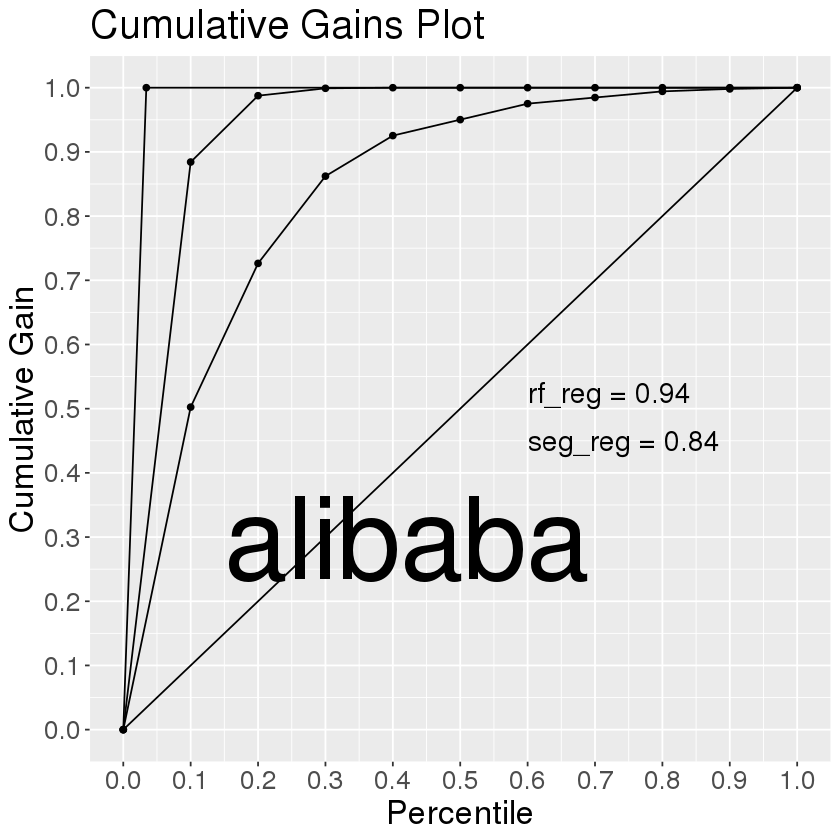

In [51]:
plot_multigains_reg <- plot_multigains(
    lift_df_list=list(
        rf_reg = lift_df_ranger_03_reg,
        seg_reg = lift_df_seg_glm_expiry_exptest_reg),
    auc_list = list(
        rf_reg= calc_auc(lift_df_ranger_03_reg),
        seg_reg= calc_auc(lift_df_seg_glm_expiry_exptest_reg)),
    prop_positive = prop_positive)
# png(file = "../../data/output/plot_multigains_03_summ4.png",
#     width = 500, height = 375)
plot(plot_multigains_reg + 
      annotate("text", x = .15, y = .3, hjust = 0, label=reg_name, size = 24))
# dev.off()

# And then? No and then!

In [52]:
reg_name='go daddy'

In [53]:
# RF 

# subset data

dim(expiry_train_df_sub)
dim(expiry_test_df_sub)
cat('\n')

expiry_train_df_sub_reg <- expiry_train_df_sub %>% filter(registrar==reg_name)
expiry_test_df_sub_reg <- expiry_test_df_sub %>% filter(registrar==reg_name)


dim(expiry_train_df_sub_reg)
dim(expiry_test_df_sub_reg)
cat('\n')


dim(expiry_train_df_sub_reg)/dim(expiry_train_df_sub)
dim(expiry_test_df_sub_reg)/dim(expiry_test_df_sub)

# train & test RF
ranger_03_reg <- ranger(
    formula         = renewal_status ~ ., 
    data            = expiry_test_df_sub_reg, 
    importance = 'impurity', 
    num.trees       = 1000,
    probability = TRUE,
    mtry            = 3,
    min.node.size   = 10,
    replace = FALSE,
    sample.fraction = .8,
    seed            = 123
)

ranger_predict_03_reg <- predict(ranger_03_reg, 
                          data = expiry_test_df_sub_reg,
                          type="response")$predictions

ranger_predict_03_reg <- as.data.frame(ranger_predict_03_reg)$Renewed

ranger_03_pred_df_reg = data.frame("actual" = expiry_test_df_sub_reg$renewal_status,
          "predicted" = ranger_predict_03_reg)

lift_df_ranger_03_reg <- chart_lift(pred_df = ranger_03_pred_df_reg,
                        dep_var = "actual",
                        pred_var = "predicted")

gains_plot_ranger_03_reg <- plot_gains (lift_df_ranger_03_reg) 

auc_ranger_03_reg <- calc_auc(lift_df_ranger_03_reg)

# save(ranger_03_reg, file="../../data/output/ranger_03_reg")
# save(ranger_predict_03_reg, 
#      file="../../data/output/ranger_predict_03_reg")
# saveRDS(lift_df_ranger_03_reg, file.path('../../data/output/',"lift_df_ranger_03_reg"))



[1] 1188250      12

[1] 296797     12

[1] 108988     12

[1] 27537    12

[1] 0.09172144 1.00000000

[1] 0.09278059 1.00000000

In [62]:
head(expiry_test_df_sub_reg)

renewal_status,tld,registrar,reseller_country,region,reg_period,sld_type,sld_length,day_domains,gibb_score,pattern_domain_count,reg_arpt
<fct>,<fct>,<chr>,<chr>,<chr>,<int>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>
Renewed,fun,go daddy,United States,Non China,3,l,7,1,7.66,1,10.83
Not Renewd,fun,go daddy,United States,Non China,2,l,14,1,3.74,1,8.75
Not Renewd,fun,go daddy,United States,Non China,2,l,8,1,7.77,1,8.75
Renewed,fun,go daddy,United States,Non China,2,l,13,1,5.42,1,8.00
Renewed,fun,go daddy,United States,Non China,2,l,6,1,5.32,1,8.00
Renewed,fun,go daddy,United States,Non China,2,ln,7,2,2.87,1,8.00


In [63]:
expiry_test_df_sub_reg$renewal_prediction <- ranger_predict_03_reg
head(expiry_test_df_sub_reg)

renewal_status,tld,registrar,reseller_country,region,reg_period,sld_type,sld_length,day_domains,gibb_score,pattern_domain_count,reg_arpt,renewal_prediction
<fct>,<fct>,<chr>,<chr>,<chr>,<int>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>
Renewed,fun,go daddy,United States,Non China,3,l,7,1,7.66,1,10.83,0.6977748
Not Renewd,fun,go daddy,United States,Non China,2,l,14,1,3.74,1,8.75,0.3439872
Not Renewd,fun,go daddy,United States,Non China,2,l,8,1,7.77,1,8.75,0.4405030
Renewed,fun,go daddy,United States,Non China,2,l,13,1,5.42,1,8.00,0.4853910
Renewed,fun,go daddy,United States,Non China,2,l,6,1,5.32,1,8.00,0.6288842
Renewed,fun,go daddy,United States,Non China,2,ln,7,2,2.87,1,8.00,0.7380156


In [54]:
# seg_glm

# subset data

dim(seg_glm_expiry_exptest)
cat('\n')

seg_glm_expiry_exptest_reg <-seg_glm_expiry_exptest %>% filter(registrar==reg_name)


dim(seg_glm_expiry_exptest_reg)
cat('\n')


dim(seg_glm_expiry_exptest_reg)/dim(seg_glm_expiry_exptest)



seg_glm_expiry_exptest_pred_df_reg = data.frame("actual" = seg_glm_expiry_exptest_reg$renewal_status,
          "predicted" = seg_glm_expiry_exptest_reg$first_renewal_prediction)

lift_df_seg_glm_expiry_exptest_reg <- chart_lift(pred_df = seg_glm_expiry_exptest_pred_df_reg,
                        dep_var = "actual",
                        pred_var = "predicted")

gains_plot_seg_glm_expiry_exptest_reg <- plot_gains (lift_df_seg_glm_expiry_exptest_reg) 

auc_seg_glm_expiry_exptest_reg<- calc_auc(lift_df_seg_glm_expiry_exptest_reg)


# saveRDS(lift_df_seg_glm_expiry_exptest, file.path('../../data/output/',"lift_df_seg_glm_expiry_exptest"))

[1] 296797     40

[1] 27537    40

[1] 0.09278059 1.00000000

In [55]:
prop.table(table(seg_glm_expiry_exptest_reg$renewal_status))


   Renewed Not Renewd 
 0.1465301  0.8534699 

In [56]:
prop_positive = prop.table(table(seg_glm_expiry_exptest_reg$renewal_status))[[1]]
prop_positive

[1] 0.1465301

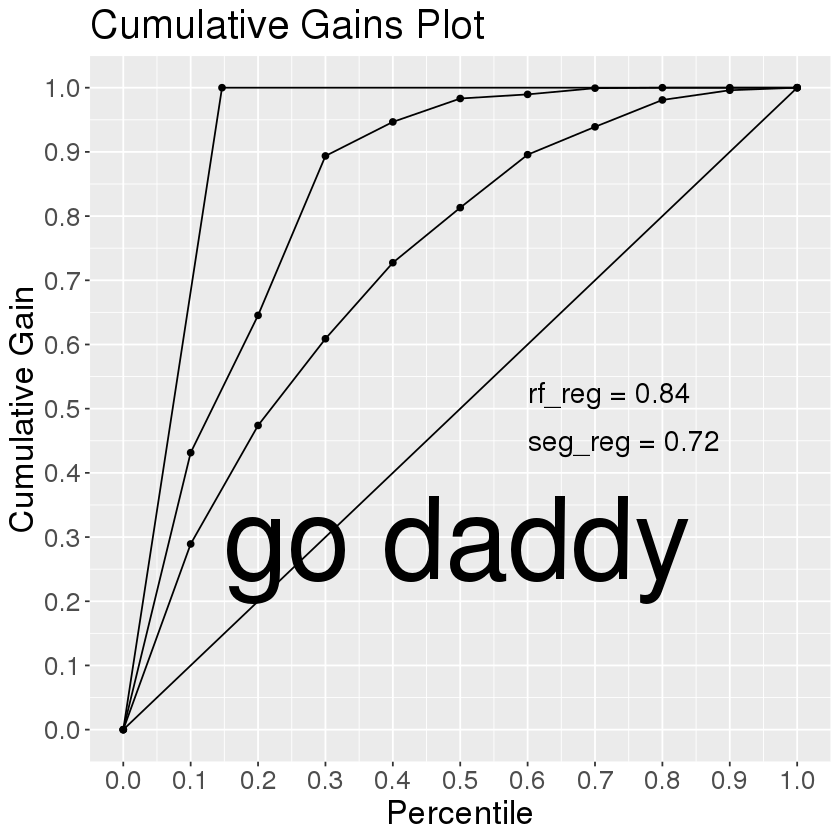

In [57]:
plot_multigains_reg <- plot_multigains(
    lift_df_list=list(
        rf_reg = lift_df_ranger_03_reg,
        seg_reg = lift_df_seg_glm_expiry_exptest_reg),
    auc_list = list(
        rf_reg= calc_auc(lift_df_ranger_03_reg),
        seg_reg= calc_auc(lift_df_seg_glm_expiry_exptest_reg)),
    prop_positive = prop_positive)
# png(file = "../../data/output/plot_multigains_03_summ4.png",
#     width = 500, height = 375)
plot(plot_multigains_reg + 
      annotate("text", x = .15, y = .3, hjust = 0, label=reg_name, size = 24))
# dev.off()

# Prototype Aggregate Segmented RF script
inputs: list of registrar segments, number of trees, parameters, train, test
script will train & test separate forest for each registrar in list and one aggregate forest for the rest of the data

In [60]:
temp <- joint_pred_df[c("reg","obs_count_s","na_count_s","tpr_0.5_s","tpr_0.5_r","aucpr_s","aucpr_r","aucpr_srrat")] %>% arrange(desc(obs_count_s))
temp$reg

[1] namecheap                  gmo                       
  [3] alibaba                    go daddy                  
  [5] pdr ltd                    reg.ru                    
  [7] chengdu west               gandi sas                 
  [9] hostinger                  zhengzhou century connect 
 [11] uniregistrar               onlinenic                 
 [13] tucows                     fbs                       
 [15] dynadot                    network solutions         
 [17] url solutions              enom                      
 [19] 1&1 internet               ovh                       
 [21] realtime register          key-systems               
 [23] namesilo                   beget                     
 [25] dotserve inc               west263 international     
 [27] hosting ukraine            domain.com - registrar    
 [29] ru-center                  hosting concepts          
 [31] nics telekom               cronon ag                 
 [33] google                     name.com                  
 [35] soluciones corporativas    shanghai meicheng         
 [37] xin net                    eranet                    
 [39] ascio                      gabia                     
 [41] united domains             global domains            
 [43] web commerce comm          porkbun                   
 [45] mesh digital               tld registrar solns       
 [47] automattic                 jogjacamp                 
 [49] rumahweb                   mat bao                   
 [51] alibaba sg                 ligne web services        
 [53] p.a viet nam               euro dns                  
 [55] bizcn                      metaregistrar             
 [57] csl                        instra corporation        
 [59] crazy domains              1api                      
 [61] gransy                     10dencehispahard          
 [63] internetx                  diamatrix                 
 [65] shanghai best oray         xiamen chinasource        
 [67] dotname korea              liquidnet                 
 [69] nicenic                    nhan hoa software         
 [71] register.com               wild west                 
 [73] chengdu fly                ledl.net                  
 [75] promo people               netowl                    
 [77] domeneshop                 netim                     
 [79] registrator domenov        epik llc                  
 [81] 22net inc                  paragon internet          
 [83] zhengzhou zitian           epag                      
 [85] markmonitor                dinahosting               
 [87] 101 domain                 atak                      
 [89] xiamen nawang              vautron                   
 [91] web4africa                 csc corporate             
 [93] internetworx ltd           registrygate              
 [95] webnames                   ab name isp               
 [97] online sas                 marcaria.com              
 [99] melbourne it               super registry            
[101] corehub                    synergy wholesale         
[103] nameshield                 com laude                 
[105] ejee group                 domaininfo                
[107] foshan yidong              opentld b.v.              
[109] xiamen 35.com              freeparking               
[111] todaynic                   brandma                   
[113] c-soft oy                  evoplus ltd               
[115] planet hoster              blacknight                
[117] domaindiscover.com         internet gmbh             
[119] variomedia                 alpnames                  
[121] bb online                  cps-datensysteme          
[123] mijn internet              netearth one              
[125] netistrar                  safenames ltd             
[127] server plan                tecnocratica centro       
[129] beijing guoxu              dnc holdings              
[131] domain the net             ename tech                
[133] entorno digital            inames   

In [72]:

seg_rf <- function (reg_list = c('namecheap', 'gmo', 'alibaba', 'go daddy'),
                    num_trees = 5,
                    train = expiry_train_df_sub,
                    test = expiry_test_df_sub) { 
    


    li = list() 
    for (reg_name in reg_list){
        cat("Training & Testing ",reg_name," forest.\n\n")
        train_reg <- train %>% filter(registrar==reg_name)
        test_reg <- test %>% filter(registrar==reg_name)

        ranger_03_reg <- ranger(
        formula         = renewal_status ~ ., 
        data            = train_reg, 
        importance      = 'impurity', 
        num.trees       = num_trees,
        probability     = TRUE,
        mtry            = 3,
        min.node.size   = 10,
        replace         = FALSE,
        sample.fraction = .8,
        seed            = 123
        )

        ranger_predict_03_reg <- predict(ranger_03_reg, 
                                         data = test_reg,
                                         type="response")$predictions
        ranger_predict_03_reg <- as.data.frame(ranger_predict_03_reg)$Renewed

        test_reg$renewal_prediction <- ranger_predict_03_reg

        li[[reg_name]] = test_reg
    }

    cat("Training & Testing remaining aggregate forest.")
    train_reg <- train %>% filter(!(registrar %in% reg_list))
    test_reg <- test %>% filter(!(registrar %in% reg_list))

    ranger_03_reg <- ranger(
    formula         = renewal_status ~ ., 
    data            = train_reg, 
    importance      = 'impurity', 
    num.trees       = num_trees,
    probability     = TRUE,
    mtry            = 3,
    min.node.size   = 10,
    replace         = FALSE,
    sample.fraction = .8,
    seed            = 123
    )

    ranger_predict_03_reg <- predict(ranger_03_reg, 
                                     data = test_reg,
                                     type="response")$predictions

    ranger_predict_03_reg <- as.data.frame(ranger_predict_03_reg)$Renewed

    test_reg$renewal_prediction <- ranger_predict_03_reg

    li[['Other']] = test_reg
    
    test_results = rbindlist(li)
    
    return(test_results)
    }

write.csv("../../data/output/seg_rf_results.csv")



# save(ranger_03_reg, file="../../data/output/ranger_03_reg")
# save(ranger_predict_03_reg, 
#      file="../../data/output/ranger_predict_03_reg")
# saveRDS(lift_df_ranger_03_reg, file.path('../../data/output/',"lift_df_ranger_03_reg"))



Training & Testing  namecheap  forest.Training & Testing  gmo  forest.Training & Testing  alibaba  forest.Training & Testing  go daddy  forest.Training & Testing remaining aggregate forest.

In [73]:
test_results = rbindlist(li)


In [74]:
dim(test_results)

[1] 296797     13

In [75]:
dim(expiry_test_df_sub)

[1] 296797     12

# Running full scope

In [4]:
reg_list = c('namecheap', 'gmo', 'alibaba', 'go daddy') 
num_trees = 1000
train = expiry_train_df_sub
test = expiry_test_df_sub

In [5]:
li = list() 
for (reg_name in reg_list){
    cat("\nTraining & Testing ",reg_name," forest.\n")
    train_reg <- train %>% filter(registrar==reg_name)
    test_reg <- test %>% filter(registrar==reg_name)

    ranger_03_reg <- ranger(
    formula         = renewal_status ~ ., 
    data            = train_reg, 
    importance      = 'impurity', 
    num.trees       = num_trees,
    probability     = TRUE,
#         mtry            = 3,
#         min.node.size   = 10,
#         replace         = FALSE,
#         sample.fraction = .8,
    seed            = 123
    )

    ranger_predict_03_reg <- predict(ranger_03_reg, 
                                     data = test_reg,
                                     type="response")$predictions
    ranger_predict_03_reg <- as.data.frame(ranger_predict_03_reg)$Renewed

    test_reg$renewal_prediction <- ranger_predict_03_reg

    li[[reg_name]] = test_reg
}


Training & Testing  namecheap  forest.
Growing trees.. Progress: 69%. Estimated remaining time: 13 seconds.

Training & Testing  gmo  forest.

Training & Testing  alibaba  forest.

Training & Testing  go daddy  forest.


In [6]:
length(li)

[1] 4

In [8]:
sapply(li, dim)

namecheap,gmo,alibaba,go daddy
55117,31494,30567,27537
13,13,13,13


In [17]:
cat("\nTraining & Testing remaining aggregate forest.\n")
train_reg <- train %>% filter(!(registrar %in% reg_list))
test_reg <- test %>% filter(!(registrar %in% reg_list))

ranger_03_reg <- ranger(
formula         = renewal_status ~ ., 
data            = train_reg, 
importance      = 'impurity', 
num.trees       = num_trees,
    probability     = TRUE,
#     mtry            = 3,
#     min.node.size   = 10,
#     replace         = FALSE,
#     sample.fraction = .8,
seed            = 123
)

ranger_predict_03_reg <- predict(ranger_03_reg, 
                                 data = test_reg,
                                 type="response")$predictions

ranger_predict_03_reg <- as.data.frame(ranger_predict_03_reg)$Renewed


Training & Testing remaining aggregate forest.
Growing trees.. Progress: 16%. Estimated remaining time: 2 minutes, 40 seconds.
Growing trees.. Progress: 33%. Estimated remaining time: 2 minutes, 4 seconds.
Growing trees.. Progress: 51%. Estimated remaining time: 1 minute, 29 seconds.
Growing trees.. Progress: 68%. Estimated remaining time: 57 seconds.
Growing trees.. Progress: 85%. Estimated remaining time: 26 seconds.


In [19]:
test_reg$renewal_prediction <- ranger_predict_03_reg

In [20]:
li[['Other']] = test_reg

In [21]:
test_results = rbindlist(li, fill=TRUE)


In [30]:
names(li)

[1] "namecheap" "gmo"       "alibaba"   "go daddy"  "Other"

# Evaluate Aggregate Seg_RF

In [22]:

seg_rf_pred_df_reg = data.frame("actual" = test_results$renewal_status,
          "predicted" = test_results$renewal_prediction)

lift_df_seg_rf <- chart_lift(pred_df = seg_rf_pred_df_reg,
                        dep_var = "actual",
                        pred_var = "predicted")

gains_plot_seg_rf <- plot_gains (lift_df_seg_rf) 

auc_seg_rf <- calc_auc(lift_df_seg_rf)


In [28]:
auc_seg_rf

[1] 0.7740803

In [29]:
lift_df_seg_rf

P,actu_renwd2,gain,lift
<dbl>,<int>,<dbl>,<dbl>
0.1,10689,0.3936292,3.936292
0.2,15622,0.5752900,2.876450
0.3,18936,0.6973301,2.324434
0.4,21644,0.7970539,1.992635
0.5,23733,0.8739827,1.747965
0.6,25423,0.9362180,1.560363
0.7,26493,0.9756214,1.393745
0.8,26956,0.9926717,1.240840
0.9,27128,0.9990057,1.110006


In [39]:
for (list_element in names(li)){
    cat(list_element)
    cat('\n')
    print(chart_lift(pred_df =  data.frame("actual" = li[[list_element]]$renewal_status,
          "predicted" = li[[list_element]]$renewal_prediction),
                        dep_var = "actual",
                        pred_var = "predicted"))
    cat('\n')
}


namecheap
     P actu_renwd2      gain     lift
1  0.1        1120 0.3365385 3.365385
2  0.2        1619 0.4864784 2.432392
3  0.3        2003 0.6018630 2.006210
4  0.4        2334 0.7013221 1.753305
5  0.5        2628 0.7896635 1.579327
6  0.6        2866 0.8611779 1.435296
7  0.7        3050 0.9164663 1.309238
8  0.8        3190 0.9585337 1.198167
9  0.9        3285 0.9870793 1.096755
10 1.0        3328 1.0000000 1.000000

gmo
     P actu_renwd2      gain     lift
1  0.1         567 0.4153846 4.153846
2  0.2         891 0.6527473 3.263736
3  0.3        1023 0.7494505 2.498168
4  0.4        1095 0.8021978 2.005495
5  0.5        1159 0.8490842 1.698168
6  0.6        1239 0.9076923 1.512821
7  0.7        1296 0.9494505 1.356358
8  0.8        1347 0.9868132 1.233516
9  0.9        1362 0.9978022 1.108669
10 1.0        1365 1.0000000 1.000000

alibaba
     P actu_renwd2      gain     lift
1  0.1         533 0.5100478 5.100478
2  0.2         803 0.7684211 3.842105
3  0.3         930 0.88995

In [25]:
# seg_glm_expiry_exptest <- readRDS("../../data/seg_glm_expiry_exptest")

seg_glm_expiry_exptest_pred_df = data.frame("actual" = expiry_test_df_sub$renewal_status,
          "predicted" = seg_glm_expiry_exptest$first_renewal_prediction)

lift_df_seg_glm_expiry_exptest <- chart_lift(pred_df = seg_glm_expiry_exptest_pred_df,
                        dep_var = "actual",
                        pred_var = "predicted")

gains_plot_seg_glm_expiry_exptest <- plot_gains (lift_df_seg_glm_expiry_exptest) 

auc_seg_glm_expiry_exptest<- calc_auc(lift_df_seg_glm_expiry_exptest)

In [26]:
plot_multigains_03_summ5 <- plot_multigains(
    lift_df_list=list(
        seg_rf = lift_df_seg_rf,
        seg_lm = lift_df_seg_glm_expiry_exptest),
    auc_list = list(
        seg_rf= calc_auc(lift_df_seg_rf),
        seg_lm= calc_auc(lift_df_seg_glm_expiry_exptest)))
png(file = "../../data/output/plot_multigains_03_summ5.png",
    width = 500, height = 375)
plot(plot_multigains_03_summ5)
dev.off()

png 
  2

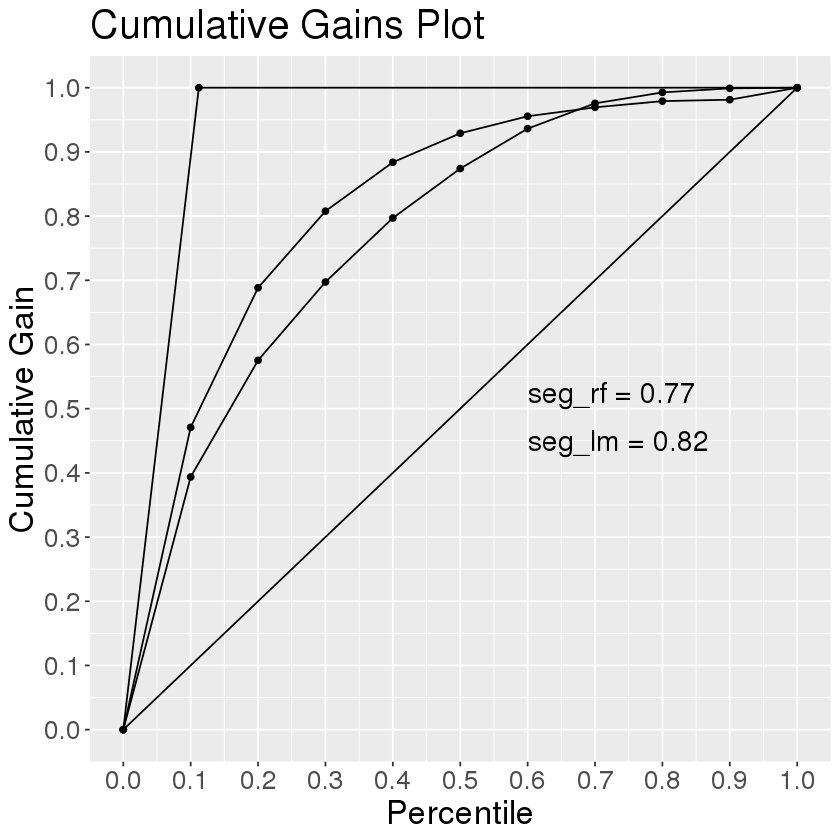

In [27]:
plot_multigains_03_summ5

In [42]:
write.csv(test_results, "../../data/output/seg_rf_results.csv")
save(li, file="../../data/output/li")

system("gsutil cp /home/jupyter/local/Domains_202003/data/output/* gs://data_outputt/output/ ")
system("mv /home/jupyter/local/Domains_202003/data/output/* /home/jupyter/local/Domains_202003/data/")
